# Machine Learning - Master IEF Parcours Quantitatif
## Prediction of Sharpe ratio for blends of quantitative strategies par Napoleon X (2019)
### Giovanni MANCHE et Antonin DEVALLAND

Lien vers le GitHub du projet : https://github.com/GiovanniManche/MachineLearning272

## 1. Sujet

### 1.1. Contexte

Le sujet que nous avons choisi de traiter concerne la prédiction du ratio de Sharpe d'un mix de stratégies quantitatives, dans le cadre d'un des *Challenge Data du Collège de France* proposé par Napoleon X. Le challenge est disponible au lien suivant : https://challengedata.ens.fr/participants/challenges/13/

Napoleon Crypto, branche de Napoleon X, est une entreprise spécialisée dans la conception de solutions d'investissement quantitatives, basées sur des algorithmes. Ayant développé plusieurs stratégies performantes, elle cherche à optimiser l'allocation entre ces stratégies pour maximiser les performances. L'objectif de ce problème est donc d'aider à la construction d'un **mélange optimal de stratégies quantitatives d'investissement** à partir de l'ensemble des stratégies soumises. Trouver la meilleure allocation parmi les stratégies quantitatives chaque semaine revient à déterminer la combinaison maximisant le ratio de Sharpe (sur les 5 prochains jours de trading). Le ratio de Sharpe permet en effet d'ajuster la performance au risque, et une combinaison optimale de stratégies devrait permettre d'obtenir un ratio de Sharpe "total" supérieur au ratio de Sharpe de chaque stratégie prise individuellement. Nous supposerons un taux sans risque nul. Avec $Lr_{i,s} = \ln \left( \frac{I_s}{I_{s-1}} \right)$ les rendements logarithmiques d'une stratégie $i$ à un temps $s$ (avec une valeur de la stratégie au temps $s$ qui vaut $I_s$), le ratio de Sharpe annualisé objectif est calculé selon la formule suivante (il est légèrement modifié pour éviter une volatilité trop proche de 0) : 
$$
S_t^*(w_1, \ldots, w_7) = \frac{\frac{252}{5} \sum_{i=1}^{7} w_i \times \left( \sum_{s=t+1}^{t+5} Lr_{i,s} \right)}{Max \left( \sqrt{252 \times \sum_{i=1}^{7} \sum_{j=1}^{7} w_i w_j \sum_{s=t-20}^{t+5} (Lr_{i,s} - \bar{Lr_i})(Lr_{j,s} - \bar{Lr_j})} ; 0.005 \right)}
$$

L'enjeu est donc, finalement, de prédire le ratio de Sharpe $S^*$ d'une combinaison donnée sur les 5 prochains jours de trading. 

### 1.2. Description des données
Pour répondre à ce sujet, Napoleon X nous fournit des données concernant 7 stratégies quantitatives qu'ils ont mis en place. Pour chaque stratégie et chaque observation ("sample") nous sont fournis les poids alloués à chaque stratégie, la valeur de chacune des stratégies sur 21 jours de trading, et les valeurs de 3 instruments financiers (inconnus) sur 21 jours de trading. Sur un même ensemble de 21 jours de trading, il peut y avoir jusqu'à 50 échantillons différents, avec les mêmes séries temporelles mais des poids différents. Autrement dit, nous pouvons avoir jusqu'à 50 échantillons sur les mêmes 21 jours, mais même si les valeurs des stratégies seront identiques (car normalisées à 100 au départ), les ratios de Sharpe seront différents en raison des poids différents. Nous avons à notre disposition trois fichiers CSV contenant : 
- les données d'entraînement (10 000 samples) : les poids alloués aux stratégies, les valeurs des stratégies et les valeurs des instruments financiers représentent les *features* initiaux. Les valeurs du labels (ratio de Sharpe), au nombre de 10 000 (1 par sample), nous sont fournies dans un CSV annexe.
- les données de test (4 450 observations par variable). Les valeurs des labels pour le *test set* ne sont pas fournies.

Les données d'entraînement et de test sont organisées de la façon suivante : 
- la première colonne correspond à l'ID de l'observation,
- les 7 colonnes suivantes correspondent aux poids alloués aux 7 stratégies qui nous sont proposées,
- les colonnes suivantes correspondent aux valeurs des autres *features* sur 21 jours de trading (séries temporelles). On a donc 21 colonnes par stratégie et par produit financiers, soit un total de : 
$$
\underbrace{1}_{ID} + \underbrace{7}_{\text{Poids}} + \underbrace{7 \times 21}_{\text{Valeurs des stratégies sur 21 jours}} + \underbrace{3 \times 21}_{\text{Valeurs des instruments sur 21 jours}} = 218 \text{ colonnes}  
$$
Les valeurs des stratégies et des instruments financiers sont normalisées à 100 au départ ($lag_{21}$). Les poids sont strictement positifs et somment à 1. Matriciellement, notre ensemble d'entraînement se représente par :
$$
X =
\begin{bmatrix}
w_1^{(1)} & w_2^{(1)} & \dots & w_7^{(1)} & I_1^{(1,t-20)} & I_1^{(1,t-19)} & \dots & I_1^{(1,t)} & \dots & I_7^{(1,t-20)} & \dots & I_7^{(1,t)} & X_1^{(1,t-20)} & \dots & X_3^{(1,t)} \\
w_1^{(2)} & w_2^{(2)} & \dots & w_7^{(2)} & I_1^{(2,t-20)} & I_1^{(2,t-19)} & \dots & I_1^{(2,t)} & \dots & I_7^{(2,t-20)} & \dots & I_7^{(2,t)} & X_1^{(2,t-20)} & \dots & X_3^{(2,t)} \\
\vdots & \vdots & \dots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
w_1^{(10000)} & w_2^{(10000)} & \dots & w_7^{(10000)} & I_1^{(10000,t-20)} & I_1^{(10000,t-19)} & \dots & I_1^{(10000,t)} & \dots & I_7^{(10000,t-20)} & \dots & I_7^{(10000,t)} & X_1^{(10000,t-20)} & \dots & X_3^{(10000,t)}
\end{bmatrix}, 
\ Y = \begin{bmatrix}
SR_1 \\
SR_2 \\
\vdots \\
SR_{10000}
\end{bmatrix}
$$

### 1.3. Description du benchmark

Chaque modèle proposé produira *in fine* des valeurs de ratio de Sharpe selon la formule présentée plus haut, et sera comparée aux vraies valeurs du ratio de Sharpe. Avant la comparaison, une fonction de lissage des extrêmes est appliquée aux résultats : 
$$
f(x) = sign(x) \times e^{-\frac{1}{abs(x)}}
$$
Une fois les résultats lissés, la métrique retenue est la moyenne des erreurs absolues : 
$$
d(y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N |f(y_i) - f(\hat{y_i})|
$$

Le benchmark proposé est de 1.200344, et correspond en fait à la moyenne des ratios de Sharpe du set d'entraînement. Outre la simplicité de calcul de ce benchmark, surpasser la moyenne du set d'entraînement est le strict minimum pour que notre modèle ait un intérêt pratique.

## 2. Problématique

Ce sujet permet ainsi de faire appel au machine learning pour proposer une réponse à une problématique absolument cruciale pour tout gestionnaire : comment optimiser l'allocation des différentes stratégies d'investissement quantitatives pour maximiser le ratio de Sharpe, ou dit plus simplement, comment ajuster le niveau d'*asset under management* au sein d'une même société de gestion entre les différentes stratégies pour maximiser la performance.

Le passage du problème financier au problème de machine learning se pose formellement. Ici, le label (ratio de Sharpe) peut *théoriquement* prendre ses valeurs dans $\mathbb{R}$, nous sommes donc face à un **problème de régression**. Dans le cadre d'un apprentissage supervisé, avec $X \in \mathcal{X}$ les *features* (bruts ou créés) et $Y \in \mathcal{Y}$ les labels (ici, uniquement le ratio de Sharpe), on cherche $h_{\theta}^*$ la meilleure approximation de la fonction de mapping $\phi : \mathcal{X} \rightarrow \mathcal{Y}$ définie telle que 
$$ y_i = \phi(x_i) + \varepsilon_i \ \forall i = {1,...,n}$$

Notre espace d'hypothèses, $\mathcal{H}$, est définissable comme l'ensemble des fonctions $f : \mathbb{R^{k}} \rightarrow \mathbb{R}$, avec $k$ le nombre de features retenu. La fonction de coût nous est imposée, il s'agit de la moyenne des erreurs absolue après transformation par la fonction de lissage $f$.

## 3. Récupération et préparation des données

### 3.1. Import des bibliothèques nécessaires 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from scipy.stats import kruskal
from sklearn.model_selection import GroupKFold
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import combinations
from typing import Tuple, Optional
import warnings
warnings.filterwarnings("ignore")

In [2]:
def smoothering_function(value: float) -> float:
    """
    Fonction lissant les valeurs extrêmes
    """
    return np.sign(value) * np.exp(-1/np.abs(value))

In [3]:
RANDOM_STATE = 42

### 3.2 Import des données et nettoyage

Le fichier CSV fourni pour l'entraînement pesait trop lourd pour le dépôt sur GitHub (plus de 35 000 Ko, alors que la limite pour déposer les données sur GitHub est de 25 000 Ko). Nous l'avons donc converti en un fichier xlsx., moins lourd, au prix d'un temps d'importation via Python allongé.

In [4]:
train_set: pd.DataFrame = pd.read_excel("Data/Train set.xlsx")
test_set: pd.DataFrame = pd.read_csv("Data/Test set.csv")
train_labels: pd.DataFrame = pd.read_csv("Data/Target values.csv")

Pour plus de simplicité, on passe la première colonne ("ID") en index.

In [5]:
train_set = train_set.set_index('ID')
test_set = test_set.set_index('ID')
train_labels = train_labels.set_index('ID')

Nous effectuons quelques vérifications pour s'assurer que le jeu de données est utilisable : 
- gestion des données manquantes
- gestion des données dupliquées
- uniformisation des formats de données
- gestion des outliers

Tout d'abord, on s'assure que les fichiers ne présentent pas de lignes dupliquées : 
- nous savons que les mêmes 21 jours peuvent être utilisés dans 50 samples au maximum, et cela sera pris en compte dans la suite,
- néanmoins ici il s'agit de s'assurer que nous n'avons jamais deux fois la même ligne, donc avec également les mêmes poids.

In [6]:
print(f"Les dimensions du train set initial sont {train_set.shape} et celles du nouveau train set sont de {train_set.drop_duplicates().shape}.")
print(f"Les dimensions du train set initial sont {test_set.shape} et celles du nouveau train set sont de {test_set.drop_duplicates().shape}.")

Les dimensions du train set initial sont (10000, 217) et celles du nouveau train set sont de (9933, 217).
Les dimensions du train set initial sont (4450, 217) et celles du nouveau train set sont de (4428, 217).


Nous supprimons les doublons du train set et du test set. Nous devons procéder aux suppressions des IDs correspondant dans le tableau contenant les labels.

In [7]:
train_set = train_set.drop_duplicates()
train_labels = train_labels.loc[train_set.index]
test_set = test_set.drop_duplicates()

# On vérifie que les dimensions sont cohérentes
print(f"Dimensions du train set après suppression des doublons: {train_set.shape}")
print(f"Dimensions des labels correspondants: {train_labels.shape}")

Dimensions du train set après suppression des doublons: (9933, 217)
Dimensions des labels correspondants: (9933, 1)


Cela étant fait, nous devons maintenant traiter les valeurs manquantes, s'il y en a. 

In [8]:
print(f"Le fichier contenant les données d'entraînement contient {train_set.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les données de test contient {test_set.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les valeurs cibles contient {train_labels.isnull().sum().sum()} données manquantes.")

Le fichier contenant les données d'entraînement contient 0 données manquantes.
Le fichier contenant les données de test contient 0 données manquantes.
Le fichier contenant les valeurs cibles contient 0 données manquantes.


Il n'y a aucune valeur manquante dans nos données, nous n'avons donc aucun traitement particulier à faire. À toutes fins utiles, on s'assure que nos données sont toutes de type float. En effet, le train set et test set sont composés de valeurs décimales (parts, valeurs des stratégies, valeurs des instruments financiers), il n'y a donc pas de raison qu'elles soient autre chose que de type float.

In [9]:
train_set = train_set.astype(float)
train_labels = train_labels.astype(float)
test_set = test_set.astype(float)

On peut désormais faire quelques vérifications sur les valeurs : 
- les valeurs des parts doivent être comprises entre 0 et 1 (répartition de l'*asset under management* entre différentes stratégies)
- la somme des parts doit être égale à 1 (tolérance de $10^{-4}$)
- les valeurs initiales des stratégies et des instruments financiers doivent être égales à 100 (initialisation)

In [10]:
# Tests sur les poids : compris entre 0 et 1 et somment à 1
# On récupère les noms des colonnes de poids
weights_columns = train_set.columns[:7]

# Ensemble d'entraînement
print(f"Dans le set d'entraînement, {((train_set[weights_columns] < 0) | (train_set[weights_columns] > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set d'entraînement, {abs((train_set[weights_columns].sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")
# Ensemble de test
print(f"Dans le set de test, {((test_set[weights_columns] < 0) | (test_set[weights_columns] > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set de test, {abs((test_set[weights_columns].sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")

# Tests sur les valeurs initiales
cols_lag_20 = [col for col in train_set.columns if "lag_20" in col]
print(f"Dans le set d'entraînement, {((train_set[cols_lag_20] != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")
print(f"Dans le set de test, {((test_set[cols_lag_20] != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")

Dans le set d'entraînement, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set d'entraînement, 0 samples ont une somme totale de poids différents de 1
Dans le set de test, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set de test, 0 samples ont une somme totale de poids différents de 1
Dans le set d'entraînement, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100
Dans le set de test, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100


Nous avons donc bien un jeu de données cohérents : les poids sont positifs, inférieurs à 1 et somment à 1, et les valeurs des stratégies sont initialisées à 100. Il reste finalement la gestion des outliers à traiter. Concrètement, dans le train set, de potentiels outliers sont présents. Le ratio de Sharpe (target value) doit contenir sensiblement les mêmes outliers, puisqu'il est calculé sur les bases des rendements du *pool* de stratégies du train set. Sur 5 jours de trading, la présence de valeurs extrêmes n'est clairement pas à exclure. Pour identifier si un travail sur les outliers est utile, regardons le boxplot et l'histogramme des ratios de Sharpe : 

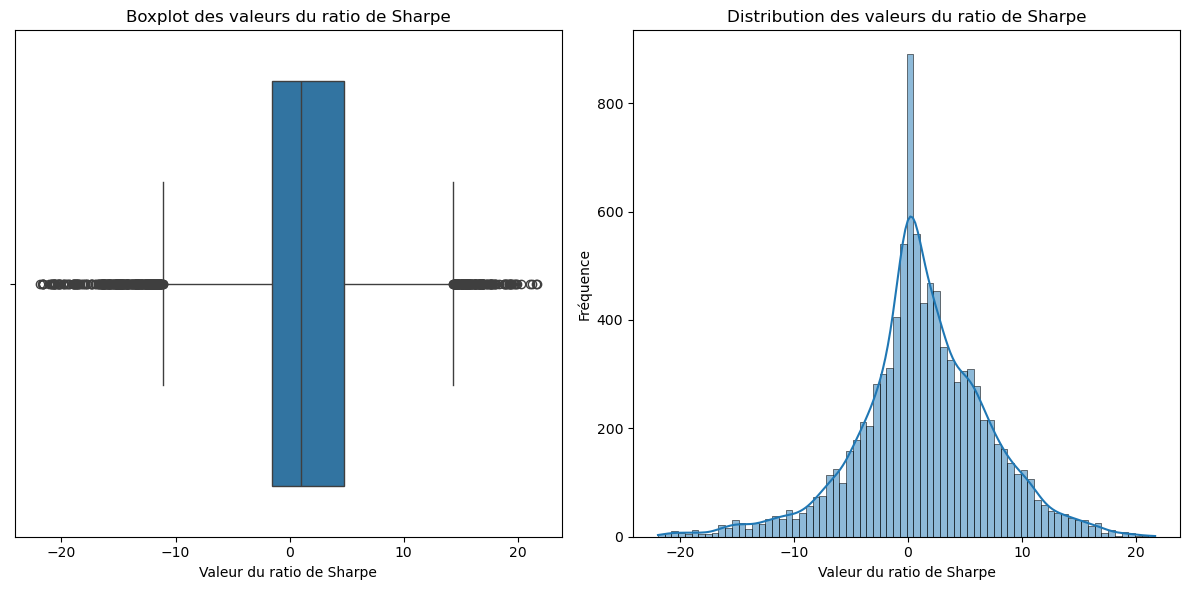

Skewness de la distribution des ratios de Sharpe : -0.263731357916495
Excès de kurtosis de la distribution des ratios de Sharpe : 1.251930574479156


In [11]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=train_labels["Target"])
plt.xlabel("Valeur du ratio de Sharpe")
plt.title('Boxplot des valeurs du ratio de Sharpe')

# Histogramme
plt.subplot(1, 2, 2)
sns.histplot(train_labels["Target"], kde=True)
plt.xlabel("Valeur du ratio de Sharpe")
plt.ylabel("Fréquence")
plt.title('Distribution des valeurs du ratio de Sharpe')

plt.tight_layout()
plt.show()
print(f"Skewness de la distribution des ratios de Sharpe : {train_labels["Target"].skew()}")
print(f"Excès de kurtosis de la distribution des ratios de Sharpe : {train_labels["Target"].kurt()}")

Ces graphiques et valeurs nous permettent de faire plusieurs commentaires : 
- La distribution des ratios de Sharpe est relativement symétrique mais légèrement décalée à gauche (skewness négatif),
- La distribution des ratios de Sharpe est leptokurtique, avec des queues de distributions plus épaisses qu'une distribution gaussienne. Cela est cohérent avec les faits stylisés des rendements financiers, qui ne suivent pas de lois gaussiennes. 
- il existe un nombre non négligeable de valeurs en dehors des premier et troisième quartiles.
Il convient de traiter le dernier point pour éviter d'éventuels biais. Pour cela, nous utilisons la méthode interquartile pour la gestion des valeurs extrêmes : 
- nous calculons l'écart interquartile $IQR = Q_3 - Q_1$,
- nous calculons les bornes de l'intervalle $[Q_1 - 1.5 \times IQR, \ Q_3 + 1.5 \times IQR]$,
- nous supprimons toute valeur en dehors de l'intervalle. 

In [12]:
# 1. Calcul des statistiques descriptives avant traitement
print("===== Statistiques descriptives avant traitement =====")
print(train_labels["Target"].describe())

# 2. Calcul des bornes de l'écart interquartile
Q1 = train_labels["Target"].quantile(0.25)
Q3 = train_labels["Target"].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

print(f"\n===== Méthode interquartile =====")
print(f"Premier quartile : {Q1:.4f}")
print(f"Troisième quartile : {Q3:.4f}")
print(f"Écart interquartile : {IQR:.4f}")
print(f"Borne inférieure : {lower_bound_iqr:.4f}")
print(f"Borne supérieure : {upper_bound_iqr:.4f}")

# 3. Identification des outliers
outliers = (train_labels["Target"] < lower_bound_iqr) | (train_labels["Target"] > upper_bound_iqr)
outlier_indices = train_labels[outliers].index
outlier_values = train_labels.loc[outlier_indices, "Target"].values

# 4. Calcul du nombre d'outliers retirés
lower_outliers = train_labels["Target"] < lower_bound_iqr
upper_outliers = train_labels["Target"] > upper_bound_iqr
n_lower_outliers = sum(lower_outliers)
n_upper_outliers = sum(upper_outliers)
total_outliers = len(outlier_indices)
pct_outliers = total_outliers / len(train_labels) * 100

print(f"\n===== Analyse des outliers =====")
print(f"Nombre total d'outliers identifiés: {total_outliers} ({pct_outliers:.2f}%)")
print(f"Outliers inférieurs: {n_lower_outliers} ({n_lower_outliers/total_outliers*100:.2f}% des outliers)")
print(f"Outliers supérieurs: {n_upper_outliers} ({n_upper_outliers/total_outliers*100:.2f}% des outliers)")
print(f"Valeur minimale des outliers: {outlier_values.min():.4f}")
print(f"Valeur maximale des outliers: {outlier_values.max():.4f}")

# 5. Création des nouveaux datasets 
train_labels_clean = train_labels[~outliers].copy()
ids_to_keep = train_labels[~outliers].index
train_set_clean = train_set.loc[ids_to_keep].copy()

# 6. Vérification des dimensions avant/après
print(f"\n===== Dimensions des datasets =====")
print(f"Avant suppression des outliers :")
print(f"- train_set: {train_set.shape}")
print(f"- train_labels: {train_labels.shape}")
print(f"\nAprès suppression des outliers:")
print(f"- train_set_clean: {train_set_clean.shape}")
print(f"- train_labels_clean: {train_labels_clean.shape}")

# 7. Vérification de la cohérence des indices
are_indices_aligned = train_set_clean.index.equals(train_labels_clean.index)
print(f"\n===== Vérification de cohérence =====")
print(f"Les indices sont alignés entre features et labels: {are_indices_aligned}")

# 8. Statistiques descriptives après traitement
print("\n===== Statistiques descriptives après traitement =====")
print(train_labels_clean["Target"].describe())

===== Statistiques descriptives avant traitement =====
count    9933.000000
mean        1.293375
std         5.806981
min       -21.902900
25%        -1.564104
50%         0.992727
75%         4.794639
max        21.665272
Name: Target, dtype: float64

===== Méthode interquartile =====
Premier quartile : -1.5641
Troisième quartile : 4.7946
Écart interquartile : 6.3587
Borne inférieure : -11.1022
Borne supérieure : 14.3328

===== Analyse des outliers =====
Nombre total d'outliers identifiés: 462 (4.65%)
Outliers inférieurs: 297 (64.29% des outliers)
Outliers supérieurs: 165 (35.71% des outliers)
Valeur minimale des outliers: -21.9029
Valeur maximale des outliers: 21.6653

===== Dimensions des datasets =====
Avant suppression des outliers :
- train_set: (9933, 217)
- train_labels: (9933, 1)

Après suppression des outliers:
- train_set_clean: (9471, 217)
- train_labels_clean: (9471, 1)

===== Vérification de cohérence =====
Les indices sont alignés entre features et labels: True

===== St

Nous supprimons moins de 5\% des données par cette méthode, et obtenons une distribution d'écart-type amoidri. Notons d'ailleurs que nous identifions plus d'outliers négatifs que positifs, ce qui est immédiatement lié à l'asymétrie à gauche de la distribution initiale des ratios de Sharpe. Maintenant que nous avons des données traitées, nous pouvons les analyser pour elle-même.

### 3.3. Analyse exploratoire

#### 3.3.1. Etudes descriptives des features

Nous pouvons d'abord présenter différentes statistiques descriptives concernant les données de l'ensemble d'entraînement. On conserve volontairement les poids (pour observer une éventuelle surpondération systématique d'une stratégie, qui viendrait biaiser la procédure), et excluons les colonnes dont le nom contient `'lag_20'`, invariantes et fixées à 100  : 

In [13]:
descriptive_stat_train = train_set_clean.drop(columns= cols_lag_20).describe()
display(descriptive_stat_train)

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_9,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0
count,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,...,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000,9471.000000
mean,0.139922,0.144874,0.137282,0.143454,0.148200,0.141078,0.145191,100.001734,100.036672,100.030043,...,100.124568,100.141313,100.198313,100.233632,100.243550,100.233325,100.253055,100.286879,100.263106,100.336723
std,0.239805,0.241474,0.236340,0.242389,0.243543,0.237624,0.241344,0.353323,0.469675,0.602818,...,1.223856,1.309598,1.385158,1.405432,1.454731,1.505686,1.589375,1.687100,1.715875,1.786230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.433199,98.207613,97.537396,...,95.431478,95.979716,95.979716,96.599608,96.478804,96.341153,96.449968,95.723877,95.642353,94.714651
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.942373,99.882164,99.884263,...,99.170771,99.263834,99.283351,99.279821,99.293031,99.138246,99.138246,99.180329,99.007832,99.237763
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.014325,100.036731,...,100.236547,100.246618,100.351856,100.364852,100.364844,100.474505,100.426310,100.572613,100.502408,100.586383
75%,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,100.094607,100.161242,100.296274,...,100.914138,100.964410,101.024243,101.110801,101.165162,101.210557,101.245583,101.237357,101.256881,101.452329
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.475880,101.350831,101.881236,...,103.869008,104.767236,105.458086,106.757012,106.549721,105.582424,107.157708,108.207867,108.207867,108.677631


Concentrons nous d'abord sur les poids. On remarque que ces derniers semblent globalement équirépartis sur l'ensemble d'entraînement (moyenne à presque $0.14 \approx \frac{1}{7}$ pour les 7 stratégies). Cela est une bonne nouvelle, puisque la surpondération systématique d'une stratégie aurait réduit l'intérêt des poids dans le travail d'entraînement, alors que le coeur du sujet réside ici (si une stratégie est pondérée en moyenne à 80%, elle expliquera presque systématiquement le ratio de Sharpe). Par ailleurs, les poids ont à peu près tous un écart-type de 24%. Cette variabilité uniforme est également rassurante, puisque nous n'avons pas des poids quasi-statiques d'une part, et des poids aléatoires d'autre part.  

Concentrons nous ensuite sur les valeurs des stratégies et des instruments financiers. On s'attend à ce que la volatilité aille croissant avec le temps (puisque les scénarios possibles se démultiplient). Il peut également être intéressant d'observer l'évolution de la valeur moyenne dans le temps : si les stratégies sont performantes, la moyenne devrait aussi augmenter. Pour voir cela, nous allons afficher les moyennes et volatilités dans le temps pour chaque valeur de stratégie et d'instruments.

In [14]:
# Etape 1 : création des fonctions annexes
def extract_by_element_and_lag(stat: str = 'mean', desc_df: pd.DataFrame = descriptive_stat_train) -> pd.DataFrame:
    """
    Fonction qui extrait une statistique spécifique pour chaque élément (stratégie ou instrument) à chaque lag.
    
    Inputs :
    -----------
    stat : Statistique à extraire ('mean', 'std', etc.)
    desc_df : DataFrame contenant les statistiques descriptives
        
    Output :
    --------
    DataFrame avec colonnes 'element', 'lag' et la statistique demandée
    """
    # On crée un dictionnaire contenant le nom de la stratégie (I_lag_nbre) ou la variable macroéconomique (X_lag_nbre),
    # le lag converti en entier et la statistique cherchée pour cet élément à ce lag.
    results = [
        {
            'element': col.split('_lag_')[0],
            'lag': int(col.split('_lag_')[1]),
            stat: desc_df.loc[stat, col]
        }
        for col in desc_df.columns if '_lag_' in col
    ]
    
    # On convertit le dictionnaire en dataframe
    result_df = pd.DataFrame(results)
    return result_df.sort_values(['element', 'lag'])

def create_line_chart(data: pd.DataFrame, stat: str, elements_I: list = None, elements_X: list = None, 
                     title: str = None, y_label: str = None) -> plt.Figure:
    """
    Fonction qui crée un graphique linéaire montrant l'évolution d'une statistique dans le temps pour différents éléments.

    Inputs :
    -----------
    data : DataFrame contenant les données à plot, au format [stratégie ou instrument    lag    statistique]
    stat : Nom de la colonne contenant la statistique à visualiser
    elements_I : Liste des stratégies à inclure (toutes les stratégies par défaut)
    elements_X : Liste des instruments à inclure (tous les instruments par défaut)
    title : Titre du graphique
    y_label : Label de l'axe des ordonnées
    """
    # Valeurs par défaut
    if elements_I is None:
        elements_I = sorted([e for e in data['element'].unique() if e.startswith('I_')])
    if elements_X is None:
        elements_X = sorted([e for e in data['element'].unique() if e.startswith('X_')])
    if title is None:
        title = f"Évolution de {stat} dans le temps"
    if y_label is None:
        y_label = stat.capitalize()
    
    fig, ax = plt.subplots(figsize= (14, 8))
    
    # On distingue les stratégies des instruments 
    colors_I = plt.cm.Blues(np.linspace(0.4, 0.9, len(elements_I)))
    colors_X = plt.cm.Reds(np.linspace(0.4, 0.9, len(elements_X)))
    
    # Stratégies
    for i, elem in enumerate(elements_I):
        subset = data[data['element'] == elem]
        ax.plot(subset['lag'], subset[stat], 'o-',
                label=elem, color=colors_I[i], linewidth=2)
    
    # Instruments
    for i, elem in enumerate(elements_X):
        subset = data[data['element'] == elem]
        ax.plot(subset['lag'], subset[stat], 's-',
                label=elem, color=colors_X[i], linewidth=2)
    
    # Personnalisation du graphique
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Lag (0 = plus récent, 19 = plus ancien)', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(0, 20))
    ax.invert_xaxis()  # Inverser l'axe x pour que le temps aille de gauche à droite
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig

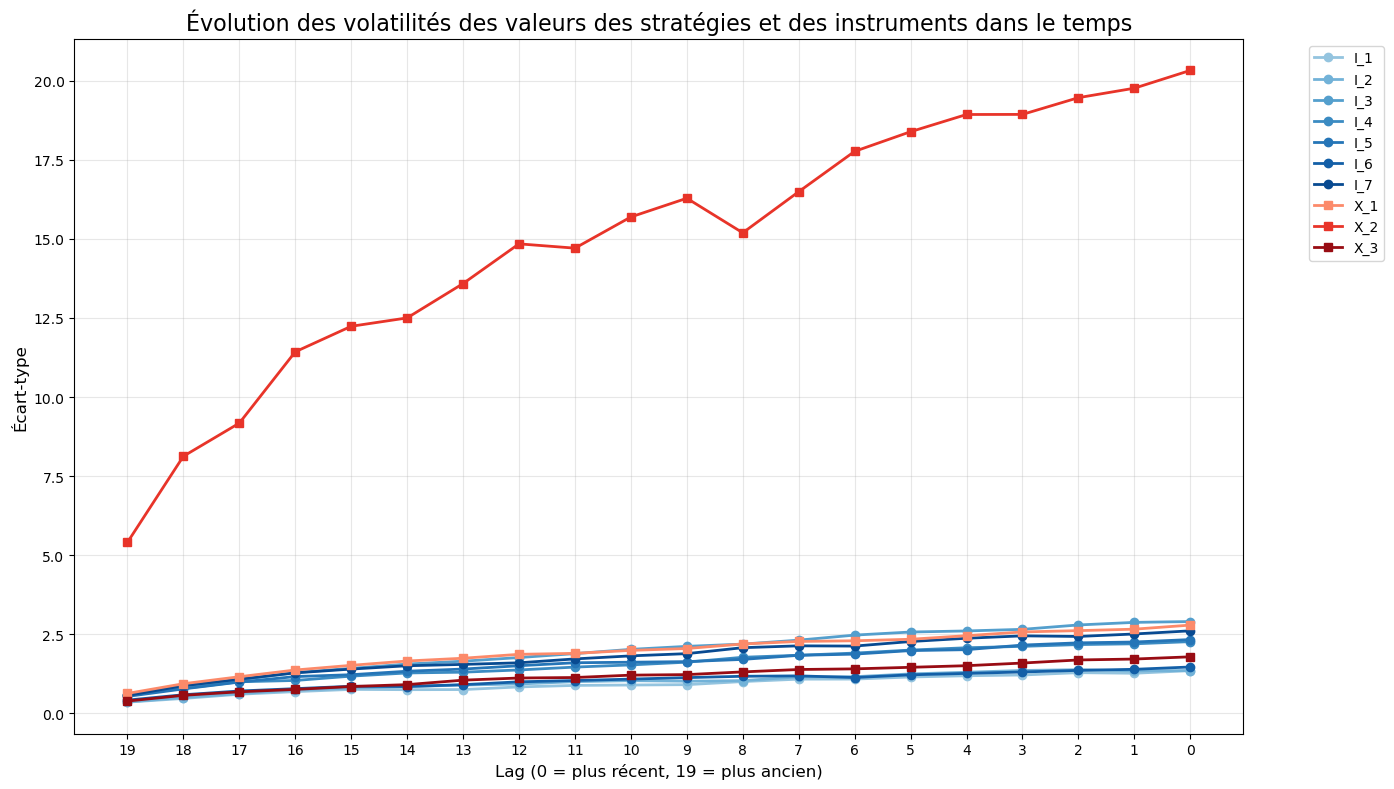

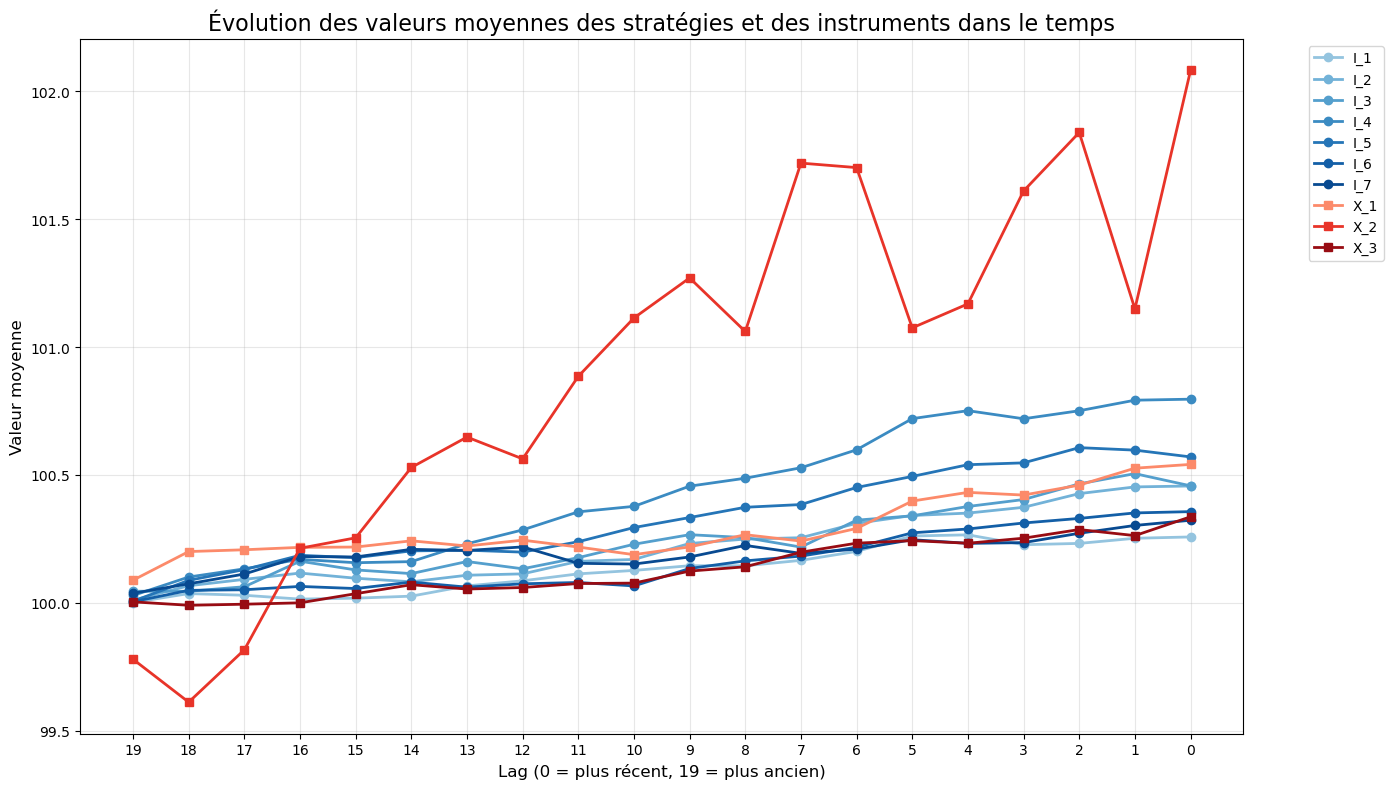

<Figure size 640x480 with 0 Axes>

In [15]:
# Etape 2 : affichage
# Récupération des moyennes et écart-types
means_by_element = extract_by_element_and_lag('mean', descriptive_stat_train)
volatility_by_element = extract_by_element_and_lag('std', descriptive_stat_train)

# On "inverse" les lags de sorte à ce que le graphique aille du plus ancien au plus récent
# 20 (données les plus anciennes) devient 0 par exemple
max_lag = means_by_element['lag'].max()
means_by_element['time'] = max_lag - means_by_element['lag']
volatility_by_element['time'] = max_lag - volatility_by_element['lag']

# Eléments à visualiser
I_elements = [f'I_{i}' for i in range(1, 8)]
X_elements = [f'X_{i}' for i in range(1, 4)]

# Filtrage 
filtered_means = means_by_element[means_by_element['element'].isin(I_elements + X_elements)]
filtered_vol = volatility_by_element[volatility_by_element['element'].isin(I_elements + X_elements)]

# Création des graphiques et affichage
fig_means = create_line_chart(
    filtered_means, 
    'mean', 
    I_elements, 
    X_elements,
    'Évolution des valeurs moyennes des stratégies et des instruments dans le temps',
    'Valeur moyenne'
)

fig_vol = create_line_chart(
    filtered_vol, 
    'std', 
    I_elements, 
    X_elements,
    'Évolution des volatilités des valeurs des stratégies et des instruments dans le temps',
    'Écart-type'
)

plt.figure(fig_means.number)
plt.show()
plt.figure(fig_vol.number)
plt.show()

On observe globalement des comportements fidèles à ceux attendus : les portefeuilles alloués aux différentes stratégies s'apprécient, de même que les valeurs des instruments. Cela témoigne d'une bonne performance des stratégies, tandis que l'interprétation des instruments est plus ardue, ceux-ci n'étant pas connu. L'instrument 2 (X_2) ressort évidemment, et présente à la fois une volatilité largement plus élevée que les autres instruments, mais offre aussi un rendement sur 20 jours plus important en moyenne. Cela est en soit conforme à la relation rendement-risque fondamentale en finance, qui énonce que les actifs les plus risqués offrent normalement des rendements espérés plus importants. L'instrument 2 ressort par son côté visiblement très risqué, et ce même sur une très courte période. En tout cas, ces éléments nous confirment la nécessité de standardiser nos données afin d'équilibrer l'influence de nos données et d'éviter que des variables à forte amplitude ne dominent les algorithmes sensibles à l'échelle.

#### 3.3.2. Etudes descriptives de la variable cible



Nous présentons ci-dessous quelques éléments de statistiques descriptives sur la variable cible :

In [16]:
descriptive_stat_target = train_labels_clean.describe()
display(descriptive_stat_target)

,Target
count,9471.000000
mean,1.535733
std,4.788286
min,-11.091926
25%,-1.259709
50%,1.061051
75%,4.679893
max,14.331762


Les ensembles de stratégies présentent un ratio de Sharpe annualisé moyen d'environ 1.5, ce qui se situe dans la tranche haute des valeurs usuelles des ratios de Sharpe. Mais ce qui est le plus frappant est tout de même la plage d'évolution de ce ratio, avec une étendue de plus de 25. On est donc face à des stratégies qui certes semblent très bien performer en moyenne, mais sont aussi très risquées. Cela se confirme par la volatilité du ratio de Sharpe. **Rappelons d'ailleurs que nous avons nettoyé nos données : les résultats sont encore plus frappants sur les données non nettoyées**.  

In [17]:
display(train_labels.describe())

,Target
count,9933.000000
mean,1.293375
std,5.806981
min,-21.902900
25%,-1.564104
50%,0.992727
75%,4.794639
max,21.665272


On peut observer que notre nettoyage a bien fait décroître la volatilité, mais a accru le ratio de Sharpe. La conclusion naturelle est qu'un plus grand nombre de ratios de Sharpe négatifs ont été purgés. 

#### 3.3.3. Corrélation entre les features

Avant d'analyser la corrélation entre nos features et le label, intéressons-nous aux corrélations entre les features eux-mêmes. En effet, des corrélations inter-features trop fortes (ou, comme on raisonne avec des séries temporelles, des cas d'autocorrélation parfois) peut réduire l'interprétabilité (difficile d'isoler l'effet individuel de chaque feature sur la prévision) et la performance du modèle (certains algorithmes sont sensibles à la multicolinéarité). En outre, cela peut aussi faciliter l'overfitting. Nous en profitons pour formellement créer un dataframe sans la colonne "lag_20" (identiques pour tout l'échantillon), et joignant les features et les labels. Nos séries étant toutes continues, on considère d'abord une corrélation "classique" (de Pearson).

In [18]:
# Copies de sécurité
train_set_clean = train_set_clean.copy()  
train_labels_clean = train_labels_clean.copy()  

# Jointure et exclusions 
merged_train_df = train_set_clean.join(train_labels_clean["Target"])
merged_train_df = merged_train_df.drop(columns = cols_lag_20)
# On vérifie que le dataframe fusionné n'a plus de lag_20 et contient "Target"
print("Set d'entraînement : ")
display(merged_train_df) 

# Corrélation linéaire 
train_correl = merged_train_df.corr()
print("Matrice de corrélation")
display(train_correl)

Set d'entraînement : 


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0,Target
ID,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.40,0.25,0.00,0.35,99.912339,99.960558,100.182904,...,100.938707,100.993926,101.132016,100.745489,100.524617,100.303743,100.276090,100.303743,100.554527,2.294867
2,0.85,0.00,0.00,0.15,0.00,0.00,0.00,99.481681,100.199593,100.408011,...,100.581716,100.313489,100.790251,101.013756,100.686030,100.686030,100.060233,99.747384,99.970889,0.652308
3,0.00,0.00,0.70,0.05,0.25,0.00,0.00,100.124618,100.023384,100.296274,...,101.040072,101.055122,101.567682,101.703322,101.974603,101.733422,101.838963,102.080144,101.688272,2.412364
4,0.00,0.55,0.05,0.00,0.00,0.00,0.40,100.000000,99.407717,99.418545,...,99.482389,99.604192,100.030499,99.847797,100.426310,100.426310,100.822217,100.913521,100.852619,8.517471
5,0.10,0.00,0.00,0.00,0.00,0.00,0.90,100.830429,101.179770,100.923997,...,101.197305,101.771363,102.345411,102.657045,102.919468,102.804653,102.870260,102.952272,102.870260,1.039912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.50,0.00,0.00,0.45,0.00,0.00,0.05,100.133669,100.200489,100.185827,...,101.768901,101.825961,102.282452,103.280979,102.738943,102.510698,102.596243,103.280979,103.223917,1.455430
9996,0.50,0.00,0.15,0.35,0.00,0.00,0.00,100.830429,101.179770,100.923997,...,101.197305,101.771363,102.345411,102.657045,102.919468,102.804653,102.870260,102.952272,102.870260,-1.532292
9997,0.10,0.00,0.00,0.00,0.00,0.65,0.25,100.000000,99.981892,99.924140,...,98.527571,97.744362,98.088972,98.057644,98.214286,97.525063,97.274436,96.773184,96.804512,3.496214


Matrice de corrélation


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0,Target
weight_I_1,1.000000,-0.169991,-0.162845,-0.173284,-0.165871,-0.163920,-0.161261,-0.006898,-0.002864,0.003300,...,-0.004970,-0.001905,-0.008024,-0.012160,-0.016722,-0.015396,-0.013723,-0.012282,-0.010957,0.015108
weight_I_2,-0.169991,1.000000,-0.166407,-0.165344,-0.173659,-0.164046,-0.165857,0.011282,0.014809,0.011667,...,-0.009828,-0.006520,0.000137,0.001825,-0.000409,0.001871,0.004190,0.003651,0.002842,0.037567
weight_I_3,-0.162845,-0.166407,1.000000,-0.162974,-0.157204,-0.163156,-0.168004,-0.003896,-0.010695,-0.010492,...,0.022343,0.021621,0.022779,0.024781,0.023530,0.018569,0.017790,0.019305,0.019173,-0.018938
weight_I_4,-0.173284,-0.165344,-0.162974,1.000000,-0.168065,-0.169440,-0.170696,0.007462,0.011351,0.004430,...,-0.003558,-0.008132,-0.004435,-0.002770,-0.001098,0.001447,0.000595,0.002565,-0.002889,0.017553
weight_I_5,-0.165871,-0.173659,-0.157204,-0.168065,1.000000,-0.168936,-0.181477,-0.003447,-0.005551,-0.012046,...,0.003125,-0.002841,-0.003237,-0.006984,-0.003637,-0.004376,-0.004134,-0.003013,0.000497,-0.001364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_3_lag_3,-0.015396,0.001871,0.018569,0.001447,-0.004376,0.006219,-0.007919,-0.054905,-0.008648,0.028407,...,0.834167,0.879685,0.907157,0.935406,0.968440,1.000000,0.967819,0.944900,0.912249,-0.017470
X_3_lag_2,-0.013723,0.004190,0.017790,0.000595,-0.004134,0.007395,-0.011685,-0.042406,-0.015442,0.030056,...,0.801907,0.849101,0.879932,0.908550,0.932296,0.967819,1.000000,0.977025,0.940970,-0.012838
X_3_lag_1,-0.012282,0.003651,0.019305,0.002565,-0.003013,0.002499,-0.012351,-0.059166,-0.022454,0.025020,...,0.788026,0.832660,0.855950,0.884837,0.907221,0.944900,0.977025,1.000000,0.966949,-0.019712
X_3_lag_0,-0.010957,0.002842,0.019173,-0.002889,0.000497,0.002940,-0.011227,-0.070599,-0.031657,0.017704,...,0.782945,0.827634,0.837023,0.866960,0.877654,0.912249,0.940970,0.966949,1.000000,-0.040535


La représentation de la matrice de corrélation n'est pas simple étant donnée sa taille. Nous proposons deux approches : 
- une approche par heatmap usuelle sur la partie triangulaire inférieure de la matrice. C'est une solution peu fine mais qui permet de voir à vue d'oeil si les corrélations sont **globalement** fortes ou faibles entre les features ;
- un affichage de l'histogramme des corrélations. Si l'on s'aperçoit qu'un nombre conséquent de corrélations sont élevées, nous investiguerons davantage.
Nous procédons également au test de significativité des corrélations : 
\begin{align*}
H_0 &: \rho_{X,Y} = 0 \\
H_1 &: \rho_{X,Y} \neq 0
\end{align*}

Avec $n$ le nombre d'observation, la statistique de test est : 
\begin{align*}
t = \hat{\rho_{X,Y}} \times \sqrt{\frac{n-2}{1-\hat{\rho_{X,Y}}^2}} \sim St(n-2)
\end{align*}
Si la pvalue calculée est inférieure à 5% (seuil de risque de première espèce retenu), on rejette $H_0$. La fonction suivante traduit en code les éléments sus-mentionnés et permet de fournir l'analyse globale des corrélations de Pearson. 

In [19]:
def pearson_pvalue(r: float, n: int) -> float:
        """
        Calcule la p-value pour un coefficient de corrélation de Pearson donné
        Inputs : 
        ---------
        r : coefficient de corrélation
        n : nombre de samples / observations
        """
        if abs(r) == 1.0:
            return 0.0
        t = r * np.sqrt((n-2) / (1-r**2))
        p = 2 * (1 - stats.t.cdf(abs(t), n-2))
        return p

def analyze_correlations(df: pd.DataFrame, 
                         alpha: float=0.05) -> Tuple[pd.DataFrame, float]:
    """
    Analyse complète des corrélations d'un ensemble de données :
    - Matrice de corrélation
    - Distribution des coefficients de corrélation
    - Test de significativité des corrélations et distribution des p-values 
    La corrélation de Pearson est utilisée et le nombre de données est suffisamment grand pour que
    les hypothèses de normalité soient supposées (théorème central limite)
    Inputs :
        df : DataFrame à analyser
        alpha : Seuil de significativité, par défaut 0.05
    Outputs :
        Tuple contenant la matrice de corrélation et le pourcentage de corrélations significatives
    """
    # 1. Setup
    ## Matrice de corrélation
    corr_matrix = df.corr(method='pearson')
    
    ## Création du masque pour le triangle inférieur de la matrice de corrélation
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    mask_lower = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)
    
    ## 2. Affichage de la matrice de corrélation
    plt.figure(figsize=(15,12))
    sns.heatmap(corr_matrix, mask=mask_upper, cmap="coolwarm", 
                annot=False, linewidths=0.5, vmin=-1, vmax=1)
    plt.title("Matrice de Corrélation (Triangle Inférieur)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 3. Affichage de la distribution des coefficients de corrélation
    corr_values = corr_matrix.values[mask_lower]
    plt.figure(figsize=(10,6))
    sns.histplot(corr_values, bins=50, kde=True, color="royalblue")
    plt.xlabel("Coefficient de corrélation", fontsize=12)
    plt.ylabel("Fréquence", fontsize=12)
    plt.title("Distribution des coefficients de corrélation", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. Test de significativité des corrélation et distribution des p-values
    n = len(df)
    
    ## Calcul des p-values pour chaque coefficient
    pvalues = np.array([pearson_pvalue(r, n) for r in corr_values])
    
    ## Affichage de la distribution des p-values
    plt.figure(figsize=(10,6))
    plt.hist(pvalues, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=alpha, color='red', linestyle='--', 
                label=f'Seuil de significativité (p={alpha})')
    plt.title('Distribution des p-values des coefficients de corrélation', fontsize=14)
    plt.xlabel('p-value', fontsize=12)
    plt.ylabel('Fréquence', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ## Statistiques sur les p-values
    significant_count = np.sum(pvalues < alpha)
    total_count = len(pvalues)
    significant_percent = significant_count / total_count * 100
    
    print(f"Nombre de corrélations testées : {total_count}")
    print(f"Nombre de corrélations significatives (p < {alpha}) : {significant_count}")
    print(f"Pourcentage de corrélations significatives : {significant_percent:.2f}%")
    
    return corr_matrix, significant_percent

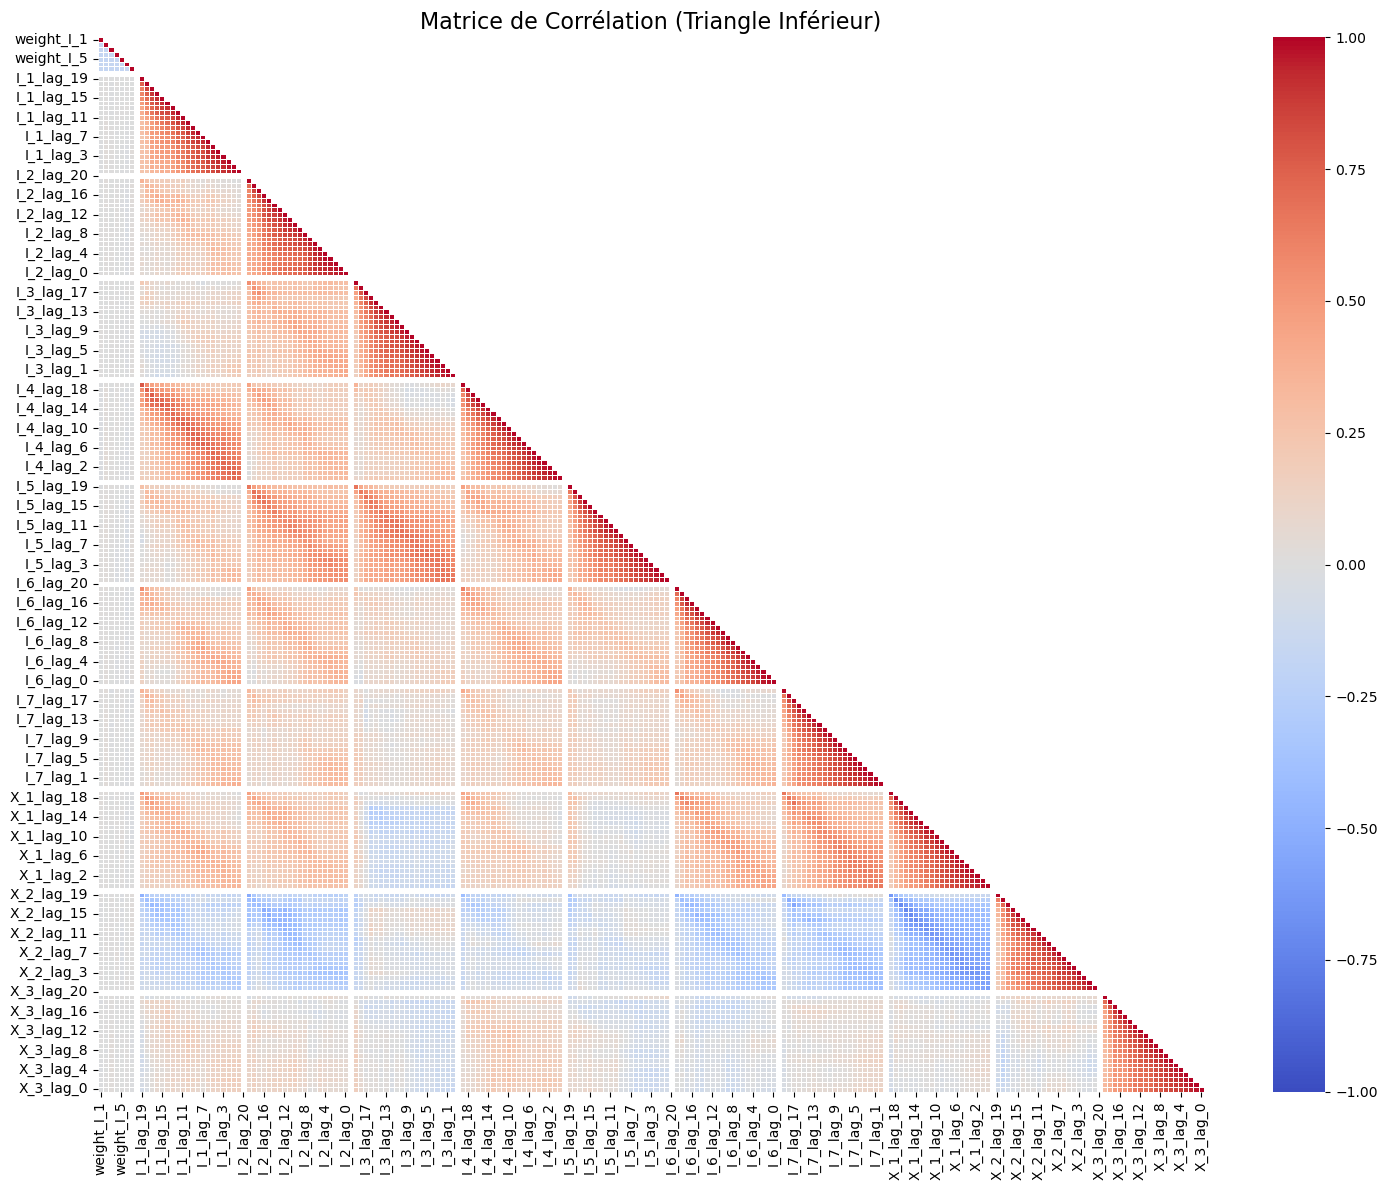

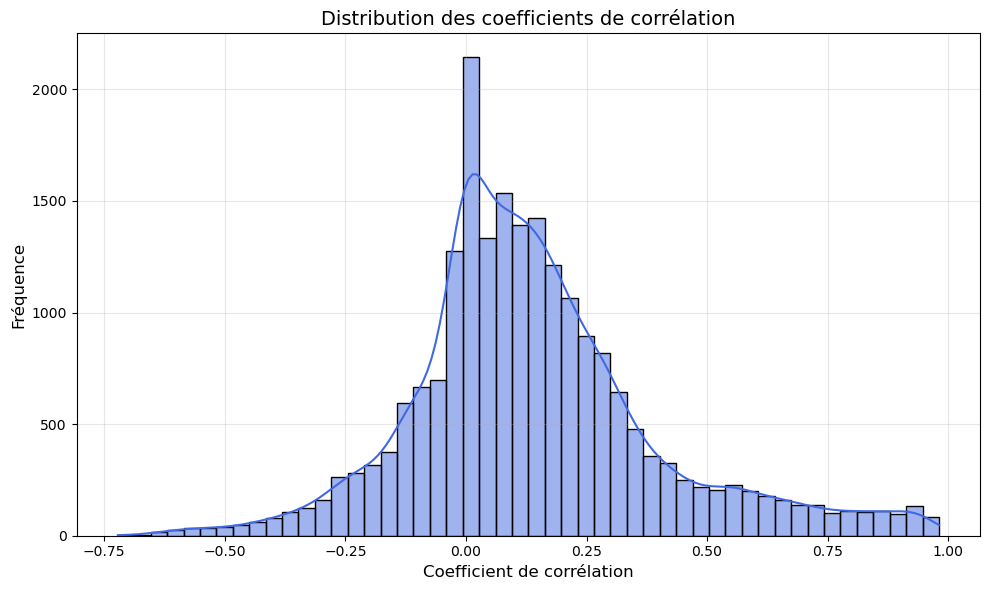

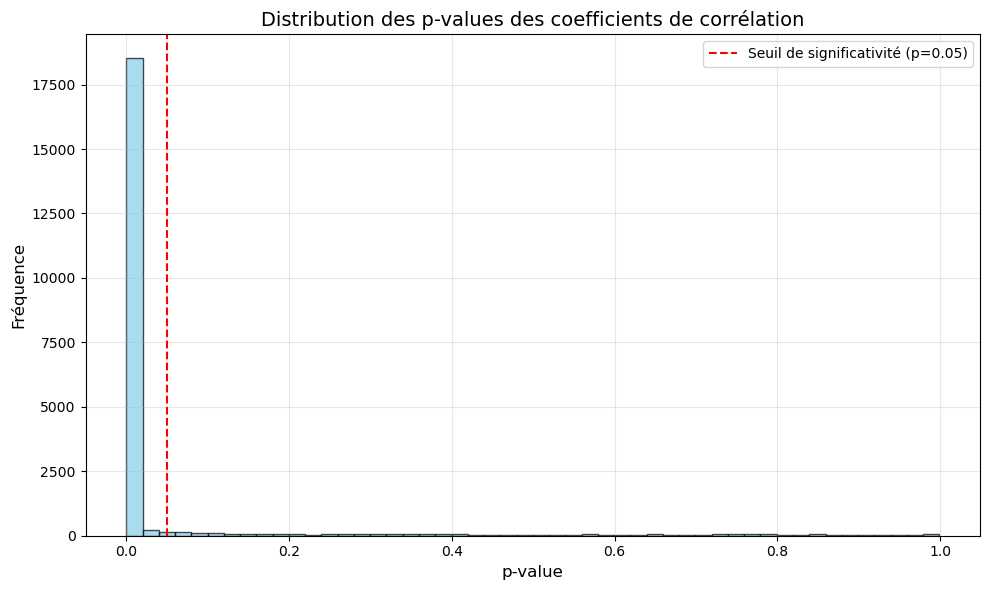

Nombre de corrélations testées : 23436
Nombre de corrélations significatives (p < 0.05) : 18829
Pourcentage de corrélations significatives : 80.34%


In [20]:
corr_matrix, significant_percent = analyze_correlations(
    df=train_set_clean,       
    alpha=0.05                
)

De ces graphiques, nous pouvons faire deux principales remarques : 
- d'un côté, les séries temporelles ne semblent pas fortement corrélées entre elles et avec les poids (zones bleues/grises) et avec les instruments financiers. Cela est positif, puisque cela nous fait penser que ces variables n'expliquent pas les mêmes éléments. 
- d'un autre côté, de fortes corrélations positives existent au sein des séries temporelles. Cela fait clairement rapport avec de l'autocorrélation dans les séries de prix, ce qui est un phénomène connu des marchés. La différenciation permet généralement d'aboutir à des séries stationnaires non autocorrélées. Nous reviendrons plus en détail sur ces points dans la suite.
- on observe que 80% des variables ont une corrélation significative. Un traitement est donc nécessaire pour augmenter le champ d'information expliqué par les variables.

#### 3.3.4. Corrélations entre les features et la cible

Désormais, il convient d'analyser les corrélations entre les features et la cible. Si la corrélation ne doit pas être trop forte (sinon c'est que la cible et le feature sont colinéaires), elle doit néanmoins être significative pour que le feature ait un intérêt. Nous utilisons d'abord la corrélation de Pearson, nos séries étant toutes continues.

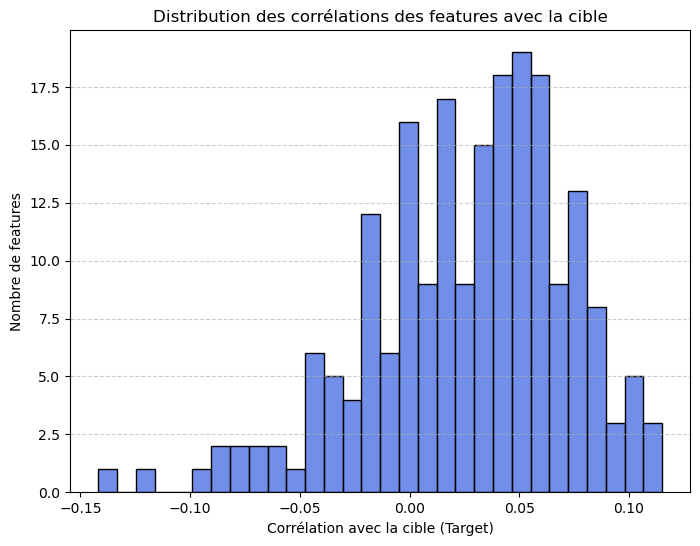

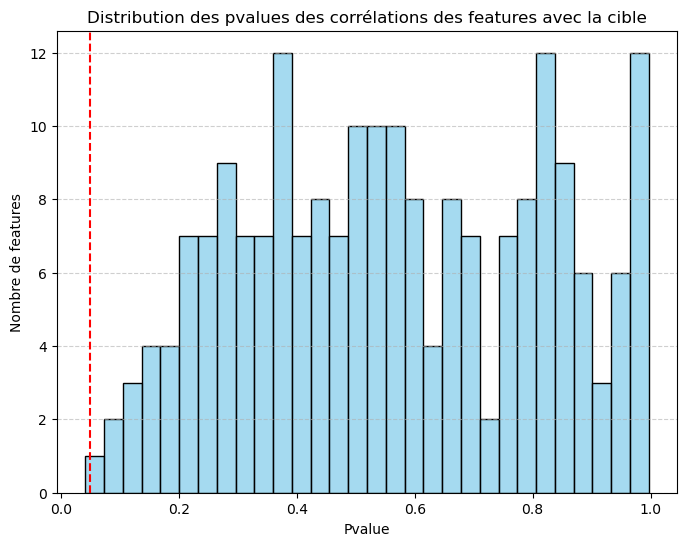

In [21]:
# On récupère les corrélations entre les features et le label
# et on calcule les pvalues
corr_target = train_correl["Target"].drop("Target")
n = len(train_correl)
pvalues = corr_target.apply(lambda r: pearson_pvalue(r, n))

# Histogramme des corrélations
plt.figure(figsize=(8, 6))
sns.histplot(corr_target, bins=30, kde=False, color="royalblue")
plt.xlabel("Corrélation avec la cible (Target)")
plt.ylabel("Nombre de features")
plt.title("Distribution des corrélations des features avec la cible")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Distributions des pvalues
plt.figure(figsize=(8, 6))
sns.histplot(pvalues, bins=30, kde=False, color="skyblue")
plt.xlabel("Pvalue")
plt.ylabel("Nombre de features")
plt.title("Distribution des pvalues des corrélations des features avec la cible")
plt.axvline(x=0.05, color='red', linestyle='--', label='Seuil de significativité (p=0.05)')
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

Les corrélations linéaires se trouvent assez proches de 0 et sont pour la plupart non significatives, ce qui est quelque peu ennuyeux puisque l'on souhaiterait que nos features soient corrélées avec notre label, par définition. On mène alors une seconde analyse : on va diviser les valeurs continues du ratio de Sharpe en catégories discrètes (binning). La transformation du label continu en une variable catégorielle nous permettra de mener le test de Kruskal-Wallis sur cette base. En effet, ce test permet de déterminer si une feature continue varie significativement entre les différentes catégories de la cible, autrement dit d'identifier les features ayant un pouvoir discriminant pour séparer les classes. 

Le **test de Kruskal-Wallis** est un test non paramétrique qui permet d'évaluer si des échantillons proviennent de la même distribution ou de distributions différentes. Dans le cadre du machine learning, il est principalement utilisé pour la sélection de features en déterminant si une feature continue présente des différences significatives entre différentes classes ou groupes de la variable cible. Le jeu d'hypothèses est : 

\begin{align*}
H_0 &: F_{X_i|Y=1}(x) = F_{X_i|Y=2}(x) = \ldots = F_{X_i|Y=k}(x) \quad \forall x \in \mathbb{R} \quad \text{(La distribution du feature est la même dans tous les groupes)}\\
H_1 &: \exists j, l \in \{1, 2, \ldots, k\}, j \neq l : F_{X_i|Y=j}(x) \neq F_{X_i|Y=l}(x) \text{ pour au moins une valeur de } x \quad \text{(Le feature a un pouvoir discriminant pour la cible)}
\end{align*}


Si la pvalue associée à ce test est inférieure à 5%, nous rejetons l'hypothèse nulle et concluons que le feature est significativement associé à la cible. 

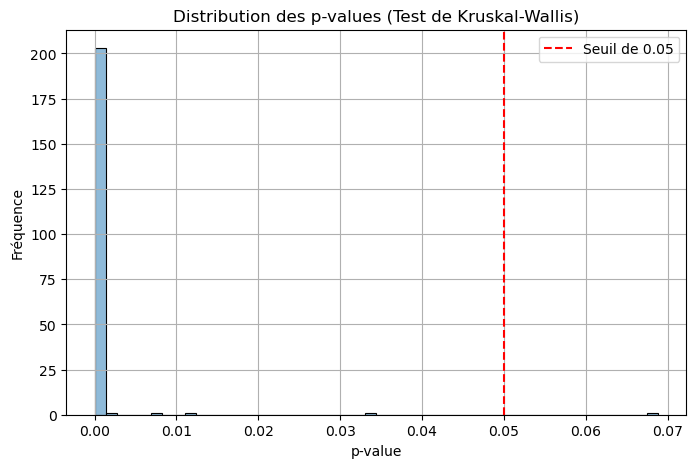

In [22]:
# On calcule le nombre de bins optimaux
num_bins = len(np.histogram_bin_edges(merged_train_df["Target"], bins="auto")) - 1
# On discrétise notre label selon le nombre optimal de bins
merged_train_df["Target_Binned"], bins = pd.qcut(merged_train_df["Target"], q=num_bins, labels=False, retbins=True)
kw_p_values = {}
# Boucle sur chaque feature 
for feature in merged_train_df.select_dtypes(include=['float64', 'int64']).columns:
    if feature != "Target":  
        # Récupération des groupes
        groups = [merged_train_df[merged_train_df["Target_Binned"] == cat][feature] for cat in np.unique(merged_train_df["Target_Binned"])]
        # Test de Kruskal-Wallis
        stat, p = kruskal(*groups)  
        kw_p_values[feature] = p

# On affiche les p-values
significant_features = {k: v for k, v in kw_p_values.items() if v < 0.05}
plt.figure(figsize=(8,5))
sns.histplot(kw_p_values.values(), bins=50, kde=False, color="royalblue") 
plt.axvline(x=0.05, color='red', linestyle='dashed', label="Seuil de 0.05")
plt.xlabel("p-value")
plt.ylabel("Fréquence")
plt.title("Distribution des p-values (Test de Kruskal-Wallis)")
plt.legend()
plt.grid()
plt.show()

Les pvalues sont inférieures à 5% (sauf une). Il y a donc (presque) systématiquement rejet de l'hypothèse nulle, les features ont un pouvoir discriminant sur le ratio de Sharpe. 

### 3.4. Nouveaux features et traitements

#### 3.4.1. Calcul des rendements

Les features que nous avons à notre disposition sont des séries de prix sur 21 jours. Le label *in fine* étant le ratio de Sharpe, calculé à partir des rendements des stratégies, nous allons modifier nos features de sorte à utiliser des rendements dans le cadre de notre projet. Cette méthode devrait en outre permettre de **réduire, voire supprimer, l'autocorrélation** dans nos séries temporelles. Les rendements logarithmiques sont utilisés dans le calcul du ratio de Sharpe, ce sont donc ceux que nous utiliserons ici.

In [23]:
def compute_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui procède au calcul des rendements des stratégies et instruments financiers.
    
    Inputs :
    ----------
    df : DataFrame contenant les features initiaux
    
    Outputs :
    ----------
    DataFrame avec les poids, suivis des rendements
    """
    # 7 premières colonnes : poids
    rdt = df.iloc[:, :7].copy()
    
    # Calcul des rendements
    columns_value_strategies = df.columns[7:]
    for i in range(len(columns_value_strategies) - 1):
        current_prices = columns_value_strategies[i]
        next_prices = columns_value_strategies[i + 1]
        col_names = f"rendement_{df.columns[i+8]}"  # cela permet d'avoir 
        # des colonnes nommées "rendement_I_lag_19" pour le rendement le plus ancien (le plus proche = lag_0)
        rdt[col_names] = np.log(df[next_prices] / df[current_prices])
    
    return rdt

# Dataframe avec poids et rendements
train_set_rdt = compute_returns(train_set_clean)
cols_rdt_20 = [col for col in train_set_rdt.columns if "lag_20" in col]
# On retire les colonnes "lag_20" car elles sont le résultat du calcul ln(X_i_lag_0/ X_j_lag_20)
train_set_rdt = train_set_rdt.drop(columns=cols_rdt_20)
display(train_set_rdt.head(5))

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,rendement_X_3_lag_9,rendement_X_3_lag_8,rendement_X_3_lag_7,rendement_X_3_lag_6,rendement_X_3_lag_5,rendement_X_3_lag_4,rendement_X_3_lag_3,rendement_X_3_lag_2,rendement_X_3_lag_1,rendement_X_3_lag_0
ID,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,0.006313,0.000273,0.000547,0.001366,-0.003829,-0.002195,-0.002200,-0.000276,0.000276,0.002497
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,-0.001336,0.002076,-0.002670,0.004741,0.002215,-0.003250,0.000000,-0.006235,-0.003132,0.002238
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,0.001197,0.001941,0.000149,0.005059,0.001335,0.002664,-0.002368,0.001037,0.002365,-0.003846
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,0.005515,-0.001835,0.001224,0.004271,-0.001828,0.005777,0.000000,0.003935,0.000905,-0.000604
5,0.10,0.00,0.00,0.00,0.00,0.0,0.90,0.008270,0.003459,-0.002531,...,0.000000,-0.003398,0.005657,0.005625,0.003040,0.002553,-0.001116,0.000638,0.000797,-0.000797


Comme sur les séries de prix, nous affichons les graphiques d'évolution des rendements moyens et volatilités moyennes par stratégie et par lag. 

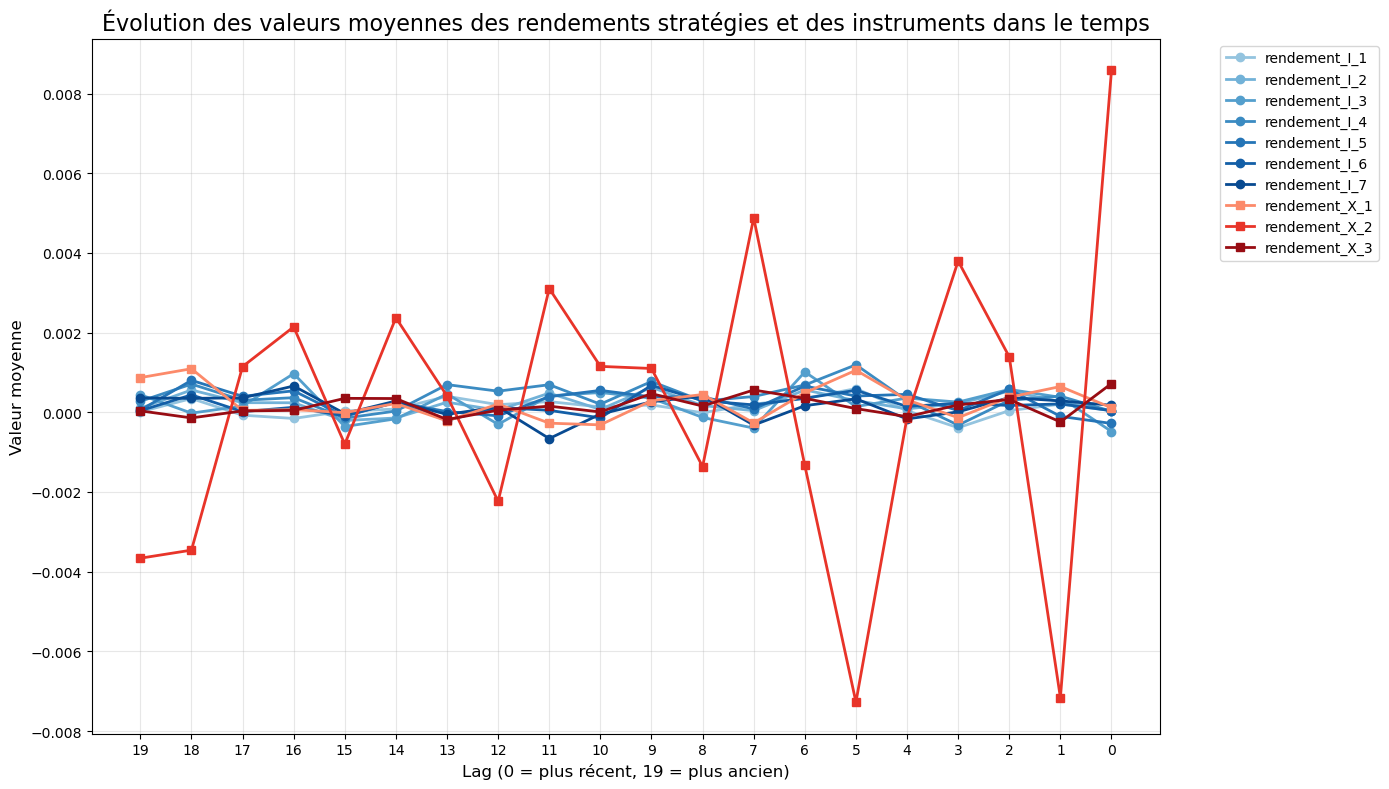

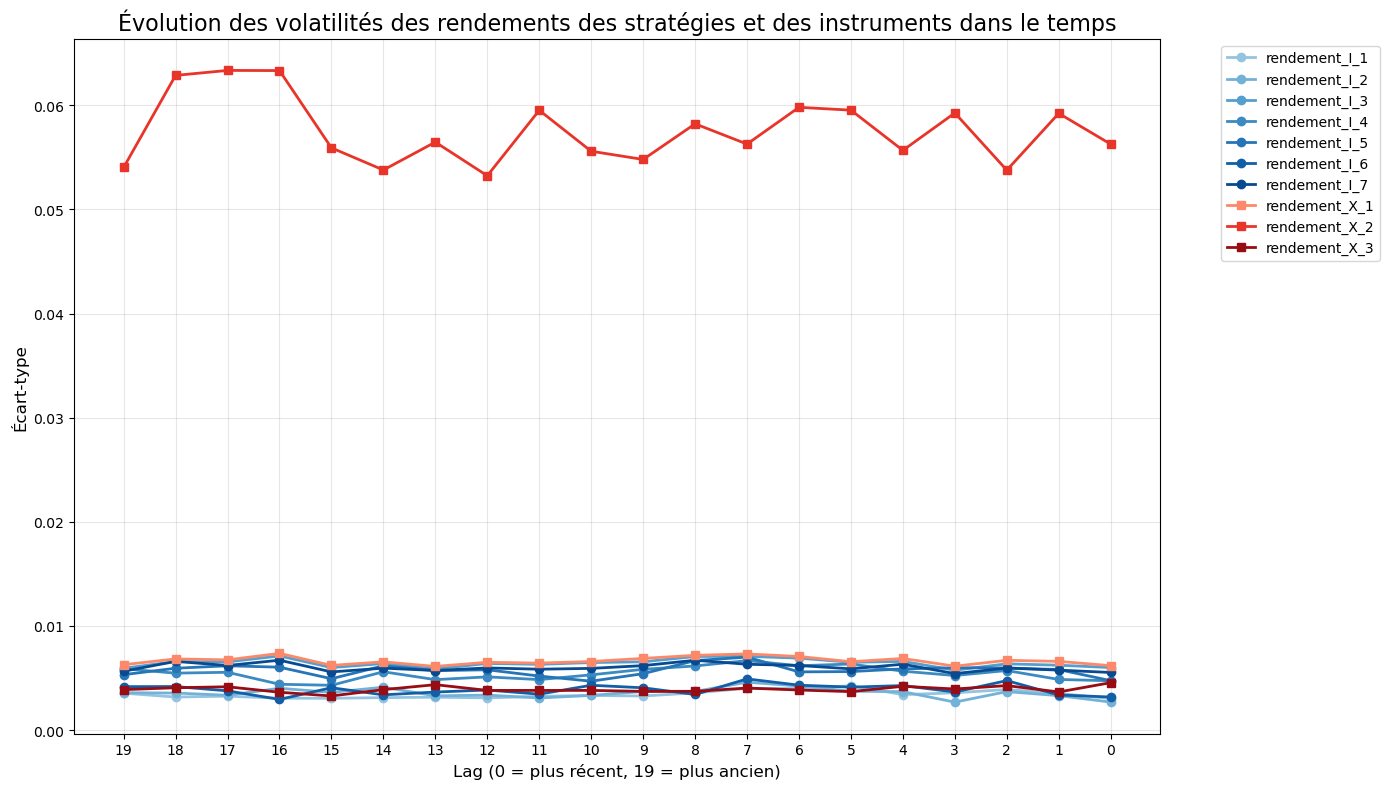

In [24]:
descriptive_stat_rdt = train_set_rdt.describe()
means_by_element_rdt = extract_by_element_and_lag('mean',descriptive_stat_rdt)
volatility_by_element_rdt = extract_by_element_and_lag('std', descriptive_stat_rdt)

# Dans nos données, lag_19 correspond aux données les plus anciennes, lag_0 les données les plus récentes.
# Pour que les graphiques aient un sens logique, on doit inverser cela.
time_periods_rdt = sorted(means_by_element_rdt['lag'].unique())
time_map_rdt = {lag: 19-lag for lag in time_periods_rdt}  # lag_19 = temps 0

# On ajoute une colonne 'time' représentant le temps (inversé par rapport au lag)
means_by_element_rdt['time'] = means_by_element_rdt['lag'].map(time_map_rdt)

# On s'assure de ne récupérer que les valeurs des stratégies ou instruments
I_elements = [f'rendement_I_{i}' for i in range(1, 8)]
X_elements = [f'rendement_X_{i}' for i in range(1, 4)]
all_elements_rdt = I_elements + X_elements
filtered_means_rdt = means_by_element_rdt[means_by_element_rdt['element'].isin(all_elements_rdt)]
filtered_vol_rdt = volatility_by_element_rdt[volatility_by_element_rdt['element'].isin(all_elements_rdt)]

# On crée les graphiques des moyennes et des volatiltés
chart1 = create_line_chart(filtered_means_rdt, 'mean',  I_elements, X_elements, 
    'Évolution des valeurs moyennes des rendements stratégies et des instruments dans le temps',
    'Valeur moyenne'
    )

chart2 = create_line_chart(filtered_vol_rdt, 'std', I_elements, X_elements, 
    'Évolution des volatilités des rendements des stratégies et des instruments dans le temps',
    'Écart-type')

plt.show()

La forte volatilité de l'instrument 2 se voit une nouvelle fois pleinement.

#### 3.4.2. Feature engineering

Nous cherchons à prédire le ratio de Sharpe d'un ensemble de stratégie. Ce dernier étant calculé depuis les rendements journaliers, faire des prédictions en ayant entraîné le modèle sur la base de ces rendements n'aurait pas vraiment d'intérêt. C'est pourquoi, il convient de créer un certain nombre de features à partir de ces rendements afin de capturer des dynamiques sous-jacentes plus complexes, qui nous permettront ensuite d'entraîner notre modèle. En plus des rendements journaliers, nous proposons les features suivants : 
- covariances entre les rendements des stratégies, entre les rendements des indicateurs économiques et entre les rendements stratégies et les rendements indicateurs économiques (cela permettra de capturer de potentielles dynamiques sous-jacentes),
- volatilités des rendements (mesure de risque au dénominateur du ratio de Sharpe),
- ratios de Sharpe hebdomadaires (pour capturer une potentielle autocorrélation dans le ratio de Sharpe);
- skewness et kurtosis des rendements (permet d'identifier des stratégies qui performent bien grâce à des valeurs extrêmes importantes de celles qui performent régulièrement. Par exemple, deux stratégies peuvent avoir le même ratio de Sharpe, mais l'une présente une distribution des rendements leptokurtique asymétrique à gauche et donc avec des drawdowns potentiellement larges et réguliers, l'autre symétrique avec faible kurtosis),
- l'indice Herfindahl-Hirschman (HHI) comme mesure de la diversification (permet de voir si le ratio de Sharpe est meilleur lorsque l'AUM est alloué de manière diversifié ou non) : 
$$
HHI = \sum_{i=1}^N \omega_i^2, \quad 0 < HHI \leq 1 \\
\begin{cases}
HHI = 1 : \text{ portefeuille totalement concentré} \\
HHI = \frac{1}{N} : \text{ portefeuille équipondéré}
\end{cases}
$$

In [25]:
def feature_engineering(df: pd.DataFrame, weights: Optional[pd.DataFrame]=None, 
                        nb_strat: int=7, nb_indic: int=3, nb_days: int=20) -> pd.DataFrame:
    """
    Fonction qui calcule toutes les features :
    - Covariances entre stratégies, indicateurs, et entre les stratégies et les indicateurs
    - Volatilités des stratégies et indicateurs
    - Skewness et kurtosis
    - Ratio de Sharpe personnalisé (si weights est fourni)
    - HHI 
    
    Inputs :
    -----------
        df: DataFrame contenant les rendements
        weights : DataFrame ou array contenant les poids (optionnel)
        nb_strat: Nombre de stratégies (7 par défaut)
        nb_indic: Nombre d'indicateurs (3 par défaut)
        nb_days: Nombre de jours de rendements (20 par défaut)
    
    Output :
    -----------
        DataFrame contenant toutes les features calculées pour chaque observation.
    """
    nb_rows = df.shape[0]
    
    # Création de paires et de noms de colonnes 
    # On récupère les nb_strat * nb_days premières colonnes pour les rendements des stratégies,
    # et le reste pour les rendements des indicateurs
    strat_cols = df.columns[:nb_strat * nb_days].tolist()
    indic_cols = df.columns[nb_strat * nb_days:(nb_strat + nb_indic) * nb_days].tolist()
    
    # 1. Définition des colonnes pour les covariances
    strat_pairs = list(combinations(range(1, nb_strat+1), 2))
    strat_strat_cols = [f'cov_I_{i}_I_{j}' for i, j in strat_pairs]
    
    indicator_pairs = list(combinations(range(1, nb_indic+1), 2))
    indic_indic_columns = [f'cov_X_{i}_X_{j}' for i, j in indicator_pairs]
    
    strat_indic_pairs = [(i, j) for i in range(1, nb_strat+1) for j in range(1, nb_indic+1)]
    strat_indic_columns = [f'cov_I_{i}_X_{j}' for i, j in strat_indic_pairs]
    
    # 2. Définition des colonnes pour les volatilités
    vol_columns = [f'vol_I_{s}' for s in range(1, nb_strat+1)] + [f'vol_X_{i}' for i in range(1, nb_indic+1)]
    
    # 3. Définition des colonnes pour le skewness et kurtosis
    skew_columns = [f'skew_I_{s}' for s in range(1, nb_strat+1)] + [f'skew_X_{i}' for i in range(1, nb_indic+1)]
    kurt_columns = [f'kurt_I_{s}' for s in range(1, nb_strat+1)] + [f'kurt_X_{i}' for i in range(1, nb_indic+1)]
    
    # 4. Colonnes pour le ratio de Sharpe et HHI (si weights fourni)
    nb_weeks = nb_days // 5
    sharpe_columns = [f'sharpe_week_{w+1}' for w in range(nb_weeks)] if weights is not None else []
    hhi_column = ['HHI'] if weights is not None else []
    
    # Combinaison de toutes les colonnes pour le tableau final
    all_columns = strat_strat_cols + indic_indic_columns + strat_indic_columns + \
        vol_columns + skew_columns + kurt_columns + sharpe_columns + hhi_column
    results = pd.DataFrame(index=range(nb_rows), columns=all_columns)
    
    # On récupère les indices des colonnes pour chaque stratégie et indicateur
    strat_indices = {}
    indic_indices = {}
    
    for s in range(1, nb_strat+1):
        strat_cols_s = strat_cols[(s-1)*nb_days:s*nb_days]
        strat_indices[s] = [df.columns.get_loc(col) for col in strat_cols_s]
    
    for i in range(1, nb_indic+1):
        indic_cols_i = indic_cols[(i-1)*nb_days:i*nb_days]
        indic_indices[i] = [df.columns.get_loc(col) for col in indic_cols_i]
    
    # Calcul de toutes les features de base
    for row_idx in range(nb_rows):
        row_values = df.iloc[row_idx].values
        
        # Extraction des données pour chaque stratégie et indicateur
        strat_data = {}
        indic_data = {}
        
        for s in range(1, nb_strat+1):
            strat_data[s] = row_values[strat_indices[s]]
        
        for i in range(1, nb_indic+1):
            indic_data[i] = row_values[indic_indices[i]]
        
        ########## Calcul des covariances ##########
        # Entre stratégies
        for col_idx, (s1, s2) in enumerate(strat_pairs):
            cov = np.cov(strat_data[s1], strat_data[s2])[0, 1]
            results.loc[row_idx, strat_strat_cols[col_idx]] = cov
        
        # Entre indicateurs
        for col_idx, (i1, i2) in enumerate(indicator_pairs):
            cov = np.cov(indic_data[i1], indic_data[i2])[0, 1]
            results.loc[row_idx, indic_indic_columns[col_idx]] = cov
        
        # Entre stratégies et indicateurs
        for col_idx, (s, i) in enumerate(strat_indic_pairs):
            cov = np.cov(strat_data[s], indic_data[i])[0, 1]
            results.loc[row_idx, strat_indic_columns[col_idx]] = cov
        
        ########## Calcul des volatilités ##########
        for s in range(1, nb_strat+1):
            vol = np.std(strat_data[s], ddof=1)
            results.loc[row_idx, f'vol_I_{s}'] = vol
        
        for i in range(1, nb_indic+1):
            vol = np.std(indic_data[i], ddof=1)
            results.loc[row_idx, f'vol_X_{i}'] = vol
        
        ########## Calcul des skewness et kurtosis ##########
        for s in range(1, nb_strat+1):
            results.loc[row_idx, f'skew_I_{s}'] = stats.skew(strat_data[s])
            results.loc[row_idx, f'kurt_I_{s}'] = stats.kurtosis(strat_data[s], fisher=True)
        
        for i in range(1, nb_indic+1):
            results.loc[row_idx, f'skew_X_{i}'] = stats.skew(indic_data[i])
            results.loc[row_idx, f'kurt_X_{i}'] = stats.kurtosis(indic_data[i], fisher=True)
        
        ########## Calcul du HHI ##########
        if weights is not None:
            # On récupère les poids pour la ligne
            if isinstance(weights, pd.DataFrame):
                w = weights.iloc[row_idx].values
            else:
                w = weights[row_idx]
            
            hhi = np.sum(w ** 2)
            results.loc[row_idx, 'HHI'] = hhi
        
        ########## Calcul des ratios de Sharpe ##########
        if weights is not None:
            # Récupérer les poids pour cette ligne
            if isinstance(weights, pd.DataFrame):
                w = weights.iloc[row_idx].values
            else:
                w = weights[row_idx]
            
            # Calcul pour chaque semaine
            for week in range(nb_weeks):
                # Indices pour la semaine
                start_idx = week * 5
                end_idx = start_idx + 5
                
                # Calcul du numérateur
                weekly_returns = np.zeros(nb_strat)
                # On calcule la somme des rendements pour chaque stratégie
                for s in range(1, nb_strat+1):
                    weekly_returns[s-1] = np.sum(strat_data[s][start_idx:end_idx])
                # Somme pondérée des rendements hebdomadaires + annualisation 
                weighted_return = np.sum(w * weekly_returns) * (252 / 5)
                
                # Calcul du dénominateur
                # Matrice de covariance
                cov_matrix = np.zeros((nb_strat, nb_strat))
                
                for i in range(1, nb_strat+1):
                    for j in range(1, nb_strat+1):
                        # On récupère tous les rendements pour les stratégies i et j
                        returns_i = strat_data[i]
                        returns_j = strat_data[j]
                        
                        # Moyennes des rendements
                        mean_i = np.mean(returns_i)
                        mean_j = np.mean(returns_j)
                        
                        # Covariance
                        dev_i = returns_i - mean_i
                        dev_j = returns_j - mean_j
                        cov_ij = np.sum(dev_i * dev_j) / (len(returns_i) - 1)
                        
                        cov_matrix[i-1, j-1] = cov_ij
                
                # Calcul de la variance du portefeuille pondéré
                portfolio_variance = np.dot(w.T, np.dot(cov_matrix, w))
                
                # Volatilité annualisée
                portfolio_volatility = np.sqrt(252 * portfolio_variance)
                
                # Seuil minimum de 0.005
                denominator = max(portfolio_volatility, 0.005)
                
                # Ratio de Sharpe
                sharpe_ratio = weighted_return / denominator
                results.loc[row_idx, f'sharpe_week_{week+1}'] = sharpe_ratio
    
    return results

def process_features(train_set_rdt: pd.DataFrame) -> pd.DataFrame:
    """
    Fonction qui permet de concaténer tous nos features : 
        - ceux créés via la fonction ci-dessus,
        - les poids,
        - les rendements journaliers.
    
    Input :
        train_set_rdt : DataFrame contenant toutes les données
    
    Output :
        DataFrame contenant toutes les features
    """
    # Colonnes par type
    cols_strategies = [col for col in train_set_rdt.columns if "rendement_I" in col]
    cols_indicators = [col for col in train_set_rdt.columns if "X" in col]
    
    # On réinitialise les index 
    features_data = train_set_rdt[cols_strategies+cols_indicators].reset_index(drop=True)
    weight_columns = train_set_rdt.iloc[:,:7].reset_index(drop=True)
    
    # On calcule toutes les features
    new_features = feature_engineering(features_data, weight_columns)
    # On ajoute les rendements bruts aux features
    rendements_df = features_data.reset_index(drop=True)
    # On ajoute les poids et les rendements
    new_features = pd.concat([weight_columns, rendements_df, new_features], axis=1)
    new_features = new_features.apply(pd.to_numeric, errors='coerce')
    # On vérifie les dimensions
    print(f"train_set_rdt: {train_set_rdt.shape}")
    print(f"new_features: {new_features.shape}")
    
    return new_features

In [26]:
features_train = process_features(train_set_rdt)
display(features_train.head(5))

train_set_rdt: (9471, 207)
new_features: (9471, 287)


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,kurt_I_6,kurt_I_7,kurt_X_1,kurt_X_2,kurt_X_3,sharpe_week_1,sharpe_week_2,sharpe_week_3,sharpe_week_4,HHI
0,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,6.990684,-0.476448,-0.476448,1.147579,-0.128676,6.285693,6.709467,0.803147,17.656251,0.345
1,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,2.673641,-0.034851,-0.034851,-0.130658,-0.902351,7.726733,-1.166057,9.987583,5.182329,0.745
2,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,3.672120,0.517233,0.517233,-0.909922,-0.772276,5.733866,6.685264,-7.017447,-1.944735,0.555
3,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,3.000790,-0.088999,-0.117941,-0.640775,0.913934,3.883034,-0.671889,3.744763,-4.886388,0.465
4,0.10,0.00,0.00,0.00,0.00,0.0,0.90,0.008270,0.003459,-0.002531,...,-0.569653,-0.546445,-0.546445,-0.276970,-0.933267,-1.794552,-4.202580,15.523326,-2.848019,0.820


Après ces calculs, on constate que certaines colonnes affichent des valeurs vides (NaN). Plus précisément, on identifie qu'elles sont présentes dans les skewness et kurtosis des rendements d'il y a 4 et 6 jours. On décide de supprimer ces colonnes. En effet, le nombre conséquent de valeurs vides dans ces 4 colonnes rend difficile la justification d'un remplacement par une valeur. De plus, le nombre conséquent de données à notre disposition devrait rendre marginal l'effet de ces suppressions.

In [27]:
pd.options.display.max_rows = None
print(f"Le fichier contenant les données d'entraînement contient {features_train.isnull().sum().sum()} données manquantes.")
features_train = features_train.dropna(axis = 1)
print(f"Le fichier contenant les données d'entraînement contient {features_train.isnull().sum().sum()} données manquantes.")

Le fichier contenant les données d'entraînement contient 3852 données manquantes.
Le fichier contenant les données d'entraînement contient 0 données manquantes.


On procède aux mêmes calculs de features sur le set de test.

In [28]:
# Calcul des rendements
test_set_rdt = compute_returns(test_set)
test_set_rdt = test_set_rdt.drop(columns=cols_rdt_20)

# Calcul des features
features_test = process_features(test_set_rdt)

# On retire les colonnes retirées du train_set 
cols_to_drop = [col for col in features_test.columns if col not in features_train]
features_test = features_test.drop(columns = cols_to_drop)
pd.options.display.max_rows = None
print(f"Le fichier contenant les données d'entraînement contient {features_test.isnull().sum()} données manquantes.")
features_test = features_test.dropna(axis = 1)
print(f"Le fichier contenant les données d'entraînement contient {features_test.isnull().sum()} données manquantes.")
pd.reset_option("max_rows")
display(features_test.head(5))

train_set_rdt: (4428, 207)
new_features: (4428, 287)
Le fichier contenant les données d'entraînement contient weight_I_1              0
weight_I_2              0
weight_I_3              0
weight_I_4              0
weight_I_5              0
weight_I_6              0
weight_I_7              0
rendement_I_1_lag_19    0
rendement_I_1_lag_18    0
rendement_I_1_lag_17    0
rendement_I_1_lag_16    0
rendement_I_1_lag_15    0
rendement_I_1_lag_14    0
rendement_I_1_lag_13    0
rendement_I_1_lag_12    0
rendement_I_1_lag_11    0
rendement_I_1_lag_10    0
rendement_I_1_lag_9     0
rendement_I_1_lag_8     0
rendement_I_1_lag_7     0
rendement_I_1_lag_6     0
rendement_I_1_lag_5     0
rendement_I_1_lag_4     0
rendement_I_1_lag_3     0
rendement_I_1_lag_2     0
rendement_I_1_lag_1     0
rendement_I_1_lag_0     0
rendement_I_2_lag_19    0
rendement_I_2_lag_18    0
rendement_I_2_lag_17    0
rendement_I_2_lag_16    0
rendement_I_2_lag_15    0
rendement_I_2_lag_14    0
rendement_I_2_lag_13    0
rendem

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,kurt_I_5,kurt_I_7,kurt_X_1,kurt_X_2,kurt_X_3,sharpe_week_1,sharpe_week_2,sharpe_week_3,sharpe_week_4,HHI
0,0.0,0.4,0.0,0.60,0.00,0.00,0.0,0.000351,-0.000789,0.000748,...,5.840880,7.596997,7.596997,3.724373,1.784159,-2.418846,0.342240,-4.046160,-19.306742,0.520
1,0.3,0.0,0.2,0.50,0.00,0.00,0.0,-0.006057,0.001465,-0.001336,...,2.513376,0.970938,0.636209,-0.723364,-0.896261,0.001941,-8.012261,-7.753187,-2.257774,0.380
2,0.0,0.2,0.0,0.80,0.00,0.00,0.0,0.015803,0.004229,-0.000325,...,10.172983,6.965874,6.965874,4.202687,1.740035,18.358062,-0.193781,0.048315,9.741636,0.680
3,0.0,0.0,0.0,0.05,0.85,0.00,0.1,-0.002680,-0.006729,0.003948,...,0.996329,-0.780076,-0.780076,0.512443,-0.017736,2.475389,5.748829,0.949667,4.440637,0.735
4,0.0,0.0,0.0,0.10,0.45,0.45,0.0,-0.000373,0.000262,-0.000345,...,1.113853,-0.145268,-0.097859,-0.096619,-0.875327,9.269699,11.726017,-1.358841,-2.415058,0.415


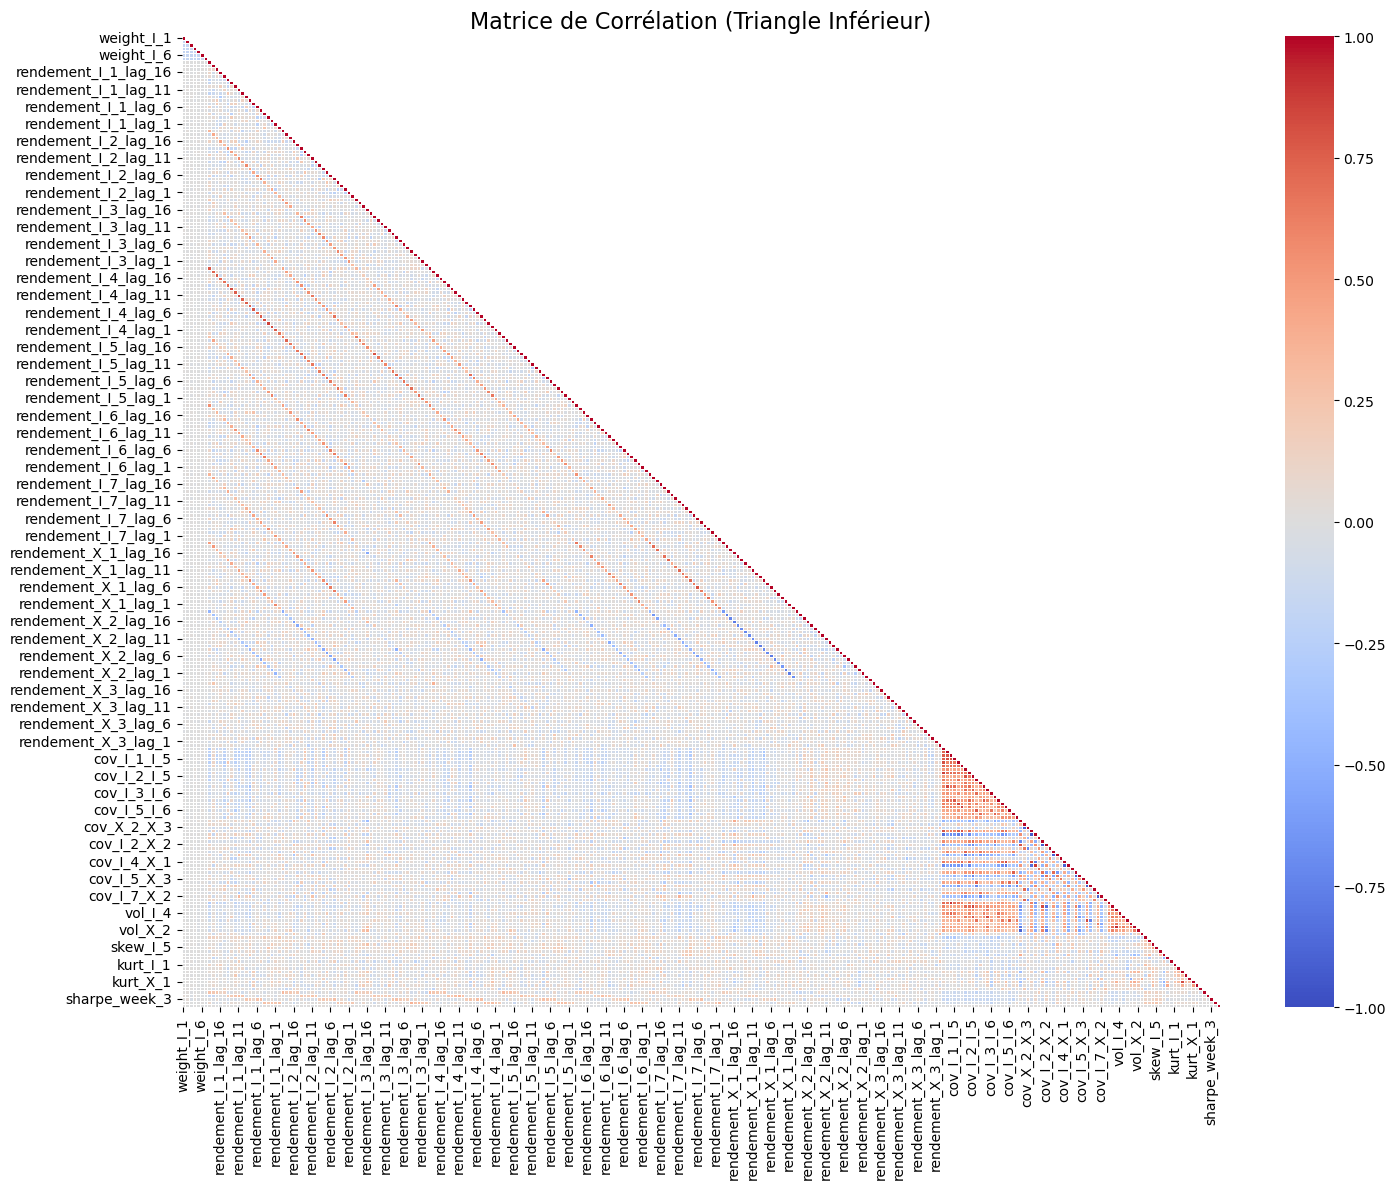

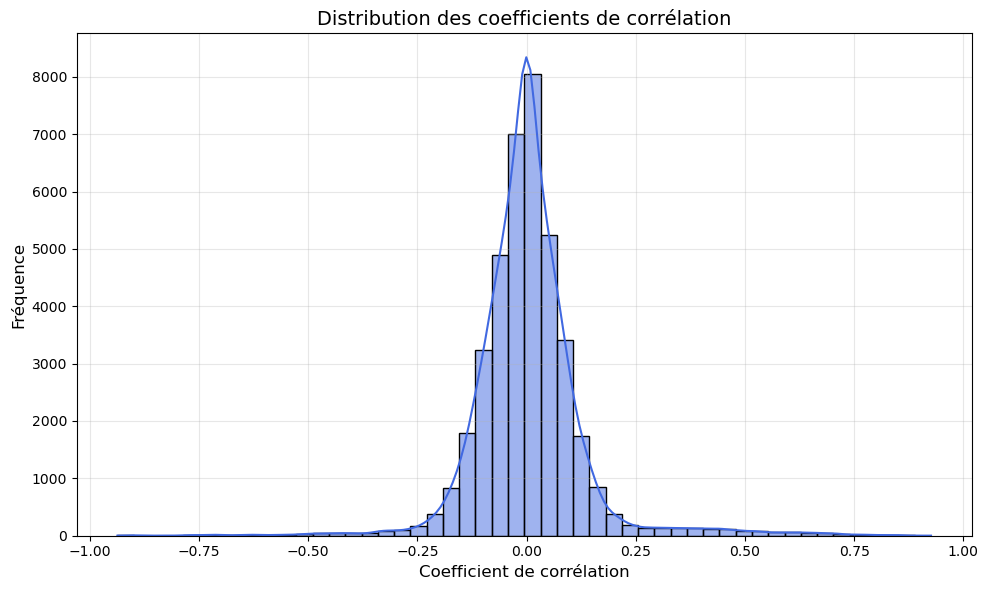

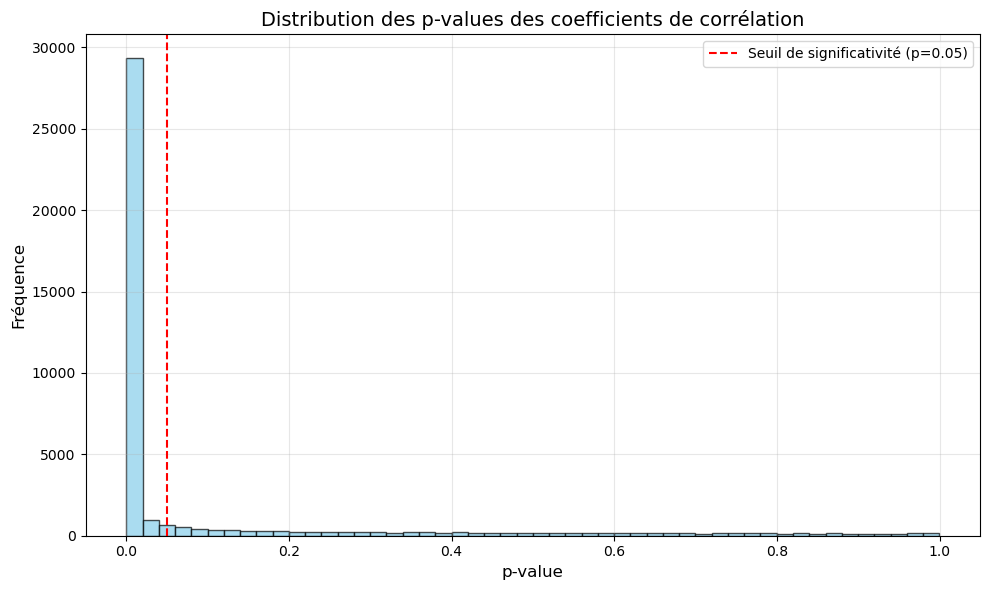

Nombre de corrélations testées : 39903
Nombre de corrélations significatives (p < 0.05) : 30665
Pourcentage de corrélations significatives : 76.85%


In [29]:
new_corr_matrix, new_significant_percent = analyze_correlations(features_train)

On constate que :
- La transformation des séries de prix en rendements logarithmiques a eu l'effet escompté : il n'y a pas d'autocorrélation apparente dans nos rendements,
- les covariances semblent, quant à elles, corrélées assez nettement entre elles : cela suggère l'existence d'une structure commune, latente, expliquant des tendances dynamiques entre plusieurs variables. 

#### 3.4.3 Cross-validation 
La division de notre dataset d'entraînement entre un *train set* et un *validation set* est nécessaire pour évaluer la capacité de notre modèle à se généraliser sur de nouvelles données. Ici, cette division n'est pas directe. En effet, rappelons notre dataset d'entraînement contient des séquences 21 jours utilisées jusqu'à 50 fois avec des combinaisons différentes de poids pour les stratégies. Pour éviter le *data leakage*, il est nécessaire de s'assurer que les observations du *train set* et du *validation set* correspondent à des séries temporelles distinctes. Un moyen de s'en assurer et de récupérer les samples ayant la même valeur finale pour une stratégie donnée (par exemple, la 2e), et de les rassembler dans des groupes. Comme chaque stratégie est normalisée à 100 au début de sa période, les observations qui présentent la même valeur finale pour une stratégie donnée correspondent nécessairement à la même séquence de 21 jours, indépendamment des poids qui sont attribués. Nous pouvons ainsi regrouper ces observations en "groupes" et nous assurer que tous les membres d'un même groupe se retrouvent soit entièrement dans le jeu d'entraînement, soit entièrement dans le jeu de validation.

Pour mettre en ouvre cette *cross-validation* respectant la structure des groupes, nous utilisons la méthode `GroupKFold` de `scikit-learn`. Concrètement, on divise les données en $k$ folds en s'assurant que tous les échantillons appartenant à un même groupe se retrouvent dans le même fold. Cela permet de garantir qu'une série temporelle utilisée pour l'entraînement n'apparaîtra jamais dans la validation, même sous une pondération différente.
La procédure se déroule comme suit :
- Nous identifions d'abord les groupes en fonction de la valeur finale d'une stratégie (arbitrairement I_2_lag_0)
- Nous attribuons un identifiant unique à chaque groupe
- Nous utilisons ces identifiants comme paramètre "groups" dans GroupKFold
- Pour chaque itération, GroupKFold sélectionne certains groupes pour l'entraînement et les autres pour la validation
- Nous évaluons la performance du modèle sur chaque fold et prenons la moyenne pour obtenir une estimation robuste

Cette approche par KFolds avec groupement préalable est nécessaire pour prévenir d'un *data leakage* : le fold pris pour validation ne contiendra pas des données datant des mêmes jours que les folds pris pour entraînement.

Notons d'ailleurs qu'il est explicitement indiqué que les séries temporelles entre le set d'entraînement et le set de test sont distinctes.

In [30]:
train_set_grouped_by_value = train_set_clean.groupby("I_2_lag_0")
for ngroup, index in enumerate(list(train_set_grouped_by_value.groups.values())):
    train_set_clean.loc[index, "Group"] = ngroup
groups = train_set_clean["Group"].values
print(f"Le nombre de séries temporelles est de : {groups.max()}.")
print(f"Le nombre minimal de séries temporelles est de : {round(features_train.shape[0]/50)}.")

# Initialisation de la cross validation utilisée plus tars 
gkf = GroupKFold(n_splits=5)

Le nombre de séries temporelles est de : 198.0.
Le nombre minimal de séries temporelles est de : 189.


#### 3.4.4. Normalisation
Nous normalisons les données afin d'éviter des problèmes d'échelle (par exemple, les poids sont de l'ordre moyen de 14%, alors que les rendements journaliers sont plutôt inférieurs à 1%). Comme nous souhaitons que les poids restent entre 0 et 1, nous faisons une normalisation Min-Max. 

Avec nos données, il n'est pas possible de mener une normalisation sur l'ensemble du dataset d'entraînement, en raison de notre raisonnement en k-folds avec regroupement préalable : pour chaque fold de la cross validation, nous devrons normaliser nos données sur la base des données d'entraînement du fold. La normalisation des données de validation se fera avec les valeurs obtenues sur les données d'entraînement.  

## 4. Sélection du modèle

Avant d'investiguer plus en détail différents modèles, nous présentons d'abord tout un panel de modèles très simples et non optimisés pour se faire une première idée du travail nécessaire. Pour cela, nous prenons 10 modèles classiques sans optimisation d'hyperparamètres.

In [31]:
def napoleon_mae(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    y_true_smooth = pd.Series(y_true).apply(smoothering_function)
    y_pred_smooth = pd.Series(y_pred).apply(smoothering_function)
    return np.mean(np.abs(y_true_smooth - y_pred_smooth))

scorer = make_scorer(napoleon_mae, greater_is_better=False)

In [32]:
# Définition des modèles à évaluer
models = {
    'XGBoost': XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()
}

results = []
test_predictions_dict = {}

# Boucle sur chaque modèle
for name, mod in models.items():
    print(f"Model: {name}")
    
    # Pipeline avec normalisation
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mod)
    ])
    
    # Scores pour chaque fold
    fold_mae_scores = []
    fold_r2_scores = []
    
    # Validation croisée avec GroupKFold
    for fold, (train_idx, val_idx) in enumerate(gkf.split(features_train, train_labels_clean, groups)):
        X_train_fold = features_train.iloc[train_idx].copy()
        y_train_fold = train_labels_clean.iloc[train_idx].copy()
        X_val_fold = features_train.iloc[val_idx].copy()
        y_val_fold = train_labels_clean.iloc[val_idx].copy()
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_val_fold)
        
        y_val_smoothed = y_val_fold.apply(smoothering_function)
        y_pred_smoothed = pd.Series(y_pred_fold.ravel()).apply(smoothering_function)
        mae_fold = napoleon_mae(y_val_fold, y_pred_fold)
        r2_fold = r2_score(y_val_smoothed, y_pred_smoothed)
        
        fold_mae_scores.append(mae_fold)
        fold_r2_scores.append(r2_fold)
        
        print(f"  Fold {fold+1}: MAE = {mae_fold:.4f}, R² = {r2_fold:.4f}")
    
    # Moyennes sur tous les folds
    mean_mae = sum(fold_mae_scores) / len(fold_mae_scores)
    mean_r2 = sum(fold_r2_scores) / len(fold_r2_scores)
    
    print(f"Cross-validation Average: MAE = {mean_mae:.4f}, R² = {mean_r2:.4f}")
    
    # Résultats
    results.append({
        'Model': name,
        'CV_MAE': mean_mae,
        'CV_R2': mean_r2
    })

# Résumé final
results_df = pd.DataFrame(results)
print("Résultats des modèles (classés par CV_MAE croissant) :")
print(results_df.sort_values('CV_MAE'))


Model: XGBoost
  Fold 1: MAE = 0.6414, R² = -0.7240
  Fold 2: MAE = 0.6418, R² = -0.5036
  Fold 3: MAE = 0.5489, R² = -0.2272
  Fold 4: MAE = 0.6630, R² = -0.6908
  Fold 5: MAE = 0.6613, R² = -0.6333
Cross-validation Average: MAE = 0.6313, R² = -0.5558
Model: Linear Regression
  Fold 1: MAE = 0.9650, R² = -2.5915
  Fold 2: MAE = 1.0432, R² = -2.6912
  Fold 3: MAE = 0.9812, R² = -2.3662
  Fold 4: MAE = 0.9849, R² = -2.3455
  Fold 5: MAE = 0.9037, R² = -2.0013
Cross-validation Average: MAE = 0.9756, R² = -2.3991
Model: Ridge Regression
  Fold 1: MAE = 0.6410, R² = -0.7652
  Fold 2: MAE = 0.6858, R² = -0.8542
  Fold 3: MAE = 0.7878, R² = -1.2427
  Fold 4: MAE = 0.7217, R² = -1.0334
  Fold 5: MAE = 0.6185, R² = -0.6789
Cross-validation Average: MAE = 0.6910, R² = -0.9149
Model: Lasso Regression
  Fold 1: MAE = 0.5328, R² = -0.1184
  Fold 2: MAE = 0.5786, R² = -0.2162
  Fold 3: MAE = 0.6012, R² = -0.3910
  Fold 4: MAE = 0.5813, R² = -0.2696
  Fold 5: MAE = 0.5856, R² = -0.3290
Cross-validat

Les résultats sont plutôt décevants, comme en témoigne le $R^2_{score}$ négatif, indiquant que le modèle fait moins bien qu'une simple prévision par la moyenne. Toutefois, ces résultats nous serviront de base pour l’optimisation et les travaux suivants. En particulier, le Support Vector Regression se distingue par sa MAE la plus faible, ce qui en fait un candidat prometteur pour une modélisation plus poussée. Nous aurons l'occasion d'y revenir.

Dans cette partie, nous allons conserver un modèle plus simple à des fins comparatives. Le dexuième meilleur modèle non optimisé, la régression Elastic Net, est idéal pour cela. L'Elastic Net combine les avantages de la régression Ridge et de la régression Lasso, ce qui lui permet à la fois de réduire la complexité du modèle et de sélectionner automatiquement les variables les plus pertinentes, tout en gérant efficacement les variables corrélées.

Mathématiquement, l'Elastic Net consiste à résoudre le problème suivant :

$$\underset{\boldsymbol{\theta}}{\text{min}} \quad \underbrace{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}_{\text{Erreur quadratique}} + \alpha \underbrace{\sum_{j=1}^{p} \left( (1 - \lambda) \theta_j^2 + \lambda |\theta_j| \right)}_{\text{Pénalité}}$$

où :
- $y_i$ est la cible réelle,
- $\hat{y}_i$ est la prédiction du modèle,
- $\boldsymbol{\theta} = (\theta_1, \dots, \theta_p)$ est le vecteur des coefficients,
- $\alpha \geq 0 $ est un hyperparamètre contrôlant l’intensité de la pénalisation,
- $\lambda \in [0,1]$ contrôle la nature de la pénalité : si $\lambda = 0$, c'est une pénalité L2, et si $\lambda = 1$, c'est une pénalité L1.  
$\alpha, \lambda$ sont les hyperparamètres que nous devons optimiser, et nous le faisons par *grid searching*, c'est-à-dire que nous testons des combinaisons d'hyperparamètres pour obtenir la combinaison offrant la meilleure performance. 

In [33]:
alphas = np.logspace(-5, 0, 5)
l1_ratios = np.linspace(0.01, 0.99, 5)  

param_grid = {
    'alpha': alphas,
    'l1_ratio': l1_ratios
}

elastic_net_model = GridSearchCV(
    estimator=ElasticNet(max_iter=5000),
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf.split(features_train, train_labels_clean, groups), 
    n_jobs=-1
)

elastic_net_model.fit(features_train, train_labels_clean)

print("Meilleurs paramètres :", elastic_net_model.best_params_)
print("MAE :", -elastic_net_model.best_score_)

Meilleurs paramètres : {'alpha': 1.0, 'l1_ratio': 0.255}
MAE : 0.5605385761915251


## 5. Benchmark

La mesure de performance demandée par le challenge est la **mean absolute error** : 
$$
MAE = \frac{1}{N} \sum_{i=1}^n | f(y_i) - f(\hat{y_i})|
$$
avec $f(x) = sign(x) \times e^{-\frac{1}{|x|}}$ une fonction visant à lisser les extrêmes, $y_i$ les vraies valeurs du label et $\hat{y_i}$ les valeurs prédites du label. 

Le benchmark proposé est simplement la moyenne : autrement dit, il s'agit du modèle qui prédit exclusivement la moyenne des ratios de Sharpe du train set. La MAE du benchmark est donc : 
$$
MAE_{bench} = \frac{1}{10000} \sum_{i=1}^n | f(y_i) - f({1.535733})|
$$
(Remarque : le sujet indique d'utiliser la valeur 1.200344, moyenne des ratios de Sharpe du set d'entraînement inital. Comme nous avons supprimé des outliers, nous utilisons la moyenne de notre set d'entraînement nettoyé, 1.535733).


In [34]:
def mean_absolute_error(real_values : pd.Series, predicted_values: pd.Series) -> float:
    """
    Fonction qui calcule la métrique de performance retenue par le challenge, la MAE
    """
    smoothed_real = real_values.copy()
    N = len(smoothed_real)
    smoothed_real = smoothed_real.apply(smoothering_function)
    smoothed_predicted = predicted_values.apply(smoothering_function)
    return (1/N) * np.sum(np.abs(smoothed_real - smoothed_predicted))

#train_labels_clean["Target"] = train_labels_clean["Target"].apply(smoothering_function)
predicted_benchmark = pd.DataFrame({'Predicted': [1.535733] * len(train_labels_clean)})
mae_benchmark = mean_absolute_error(train_labels_clean["Target"], predicted_benchmark["Predicted"])
print(f"La MAE du benchmark est de {mae_benchmark}")

La MAE du benchmark est de 0.5442741034082452


## 6. Modèle non supervisé

Bien que nous disposions des valeurs cibles, nous choisissons d’explorer dans un premier temps une approche non supervisée, dans le but d’identifier d’éventuelles structures latentes dans les données. Cette démarche se justifie notamment par nos observations précédentes concernant les corrélations marquées entre les matrices de covariance des rendements, suggérant l’existence de facteurs communs ou de dynamiques sous-jacentes. 

Pour cela, nous allons d'abord extraire des variables par décomposition en composantes principales, puis nous utilisons un algorithme K-Means sur les variables ainsi obtenues, qui permet de regrouper les observations en clusters homogènes, minimisant la variance intra-groupe. 

L'analyse en composante principale permet, en utilisant la décomposition spectrale de la matrice de covariance des features, de réduire la dimensionnalité de nos features en ne conservant que les composantes ayant un impact significatif sur la variance expliquée. Un moyen de sélectionner les composantes est la règle de Kaiser, qui préconise de ne conserver que les composantes dont la valeur propre associée est supérieure à 1 (car explique alors plus de variance qu'une feature initiale). Nous allons appliquer cette règle pour l'instant. 

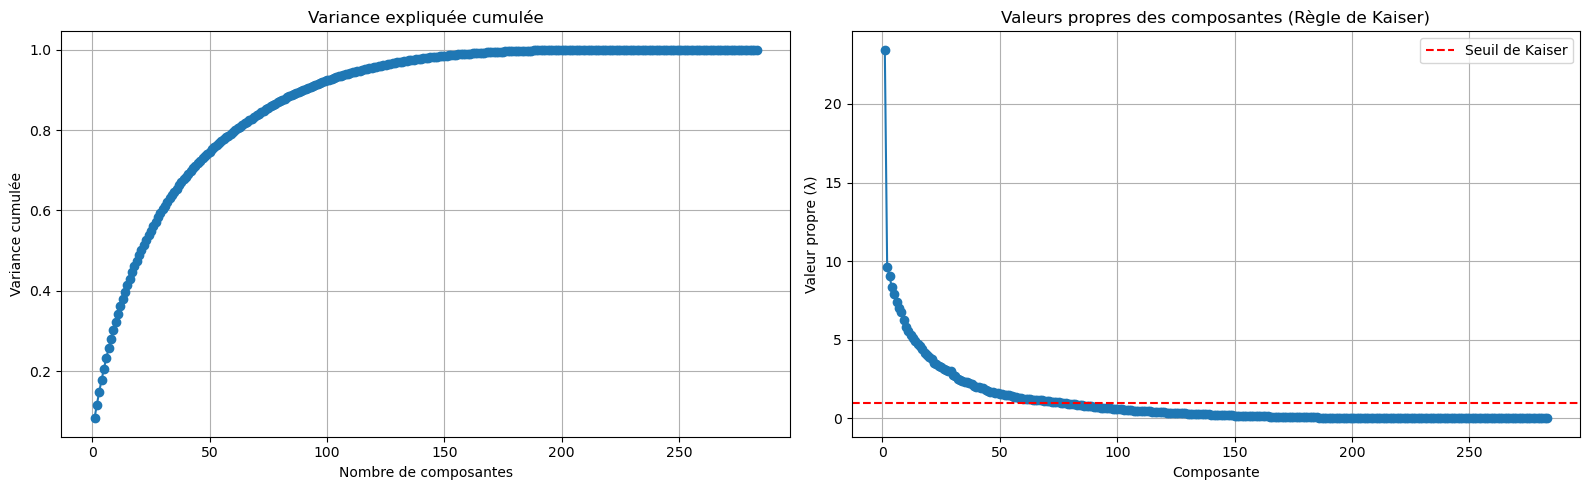

Nombre de composantes selon la règle de Kaiser: 76
Variance expliquée cumulée avec ces composantes: 85.89%


In [35]:
# Standardisation des données
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(features_train)  

# ACP
pca = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1])) 
X_pca = pca.fit_transform(X_scaled)  
# Variance expliquée 
explained_var = pca.explained_variance_ratio_ 
cum_var = np.cumsum(explained_var)  

# On récupère les valeurs propres et appliquons la règle de Kaiser
eigenvalues = pca.explained_variance_
kaiser_components = np.sum(eigenvalues > 1)

# Graphiques de la variance expliquée et des valeurs propres
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Variance expliquée cumulée
axs[0].plot(range(1, len(cum_var)+1), cum_var, marker='o')  
axs[0].set_title('Variance expliquée cumulée') 
axs[0].set_xlabel('Nombre de composantes') 
axs[0].set_ylabel('Variance cumulée') 
axs[0].grid(True) 

# Règle de Kaiser
axs[1].plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
axs[1].axhline(y=1, color='r', linestyle='--', label='Seuil de Kaiser')
axs[1].set_title('Valeurs propres des composantes (Règle de Kaiser)')
axs[1].set_xlabel('Composante')
axs[1].set_ylabel('Valeur propre (λ)')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

print(f"Nombre de composantes selon la règle de Kaiser: {kaiser_components}")
print(f"Variance expliquée cumulée avec ces composantes: {np.sum(explained_var[:kaiser_components]):.2%}")

La règle de Kaiser préconise 76 variables, ce qui reste élevé mais réduit tout de même considérablement la dimensionnalité de nos features. Dans la suite, nous utiliserons 76 composantes dès que nécessaire, et pourrons analyser l'impact d'une réduction plus forte de la dimensionnalité. 

Cela étant dit, nous pouvons maintenant créer un modèle K-Means sur la base de nos features extraits par ACP. On fixe arbitrairement le nombre de clusters à 5 (nous avons testé plusieurs nombre, et 5 paraissait être le bon arbitrage : au delà, certains clusters étaient trop dispersés, et en deça, il manquait de l'information).

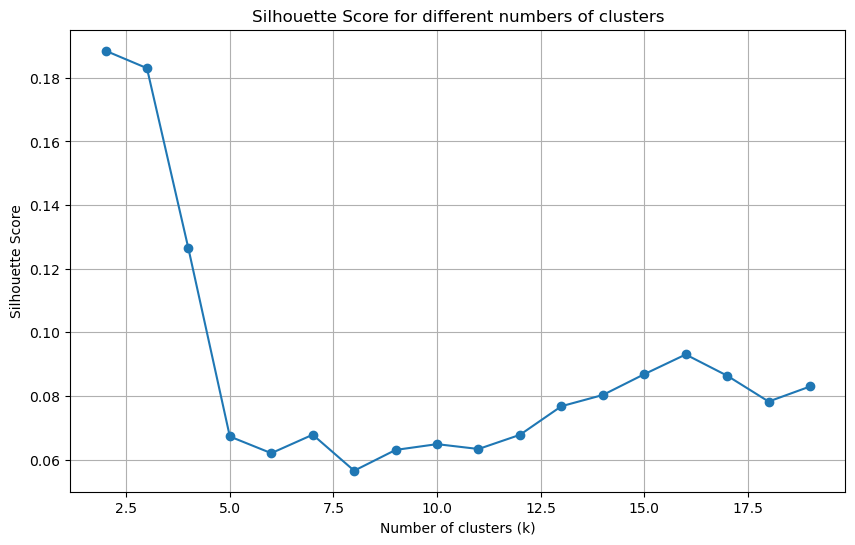

Meilleur nb de cluster : 2  pour un score de  0.18850358925363558


In [36]:
pca_76 = PCA(n_components=76) 
X_train_pca_76 = pca.fit_transform(X_scaled)  

# Fonction pour calculer le score de silhouette pour un nombre de clusters donné
def compute_silhouette_score(k, data):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    cluster_labels = kmeans.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    return score

score_sil = []
kmax = 20
for k in range(2, kmax):
    result = compute_silhouette_score(k, X_train_pca_76)
    score_sil.append(result)


# Afficher les scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot([k for k in range(2, kmax)],score_sil, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Extraire les meilleurs résultats
score = max(score_sil)
k_ideal = score_sil.index(score) + 2
print(f"Meilleur nb de cluster :",k_ideal," pour un score de ",score)


Le score de silhouette recommande 2 comme nombre de cluster idéal. Toutefois, pour que l'ajout d'un feature "cluster" soit potentiellement pertinent, on décide d'en garder 16. 

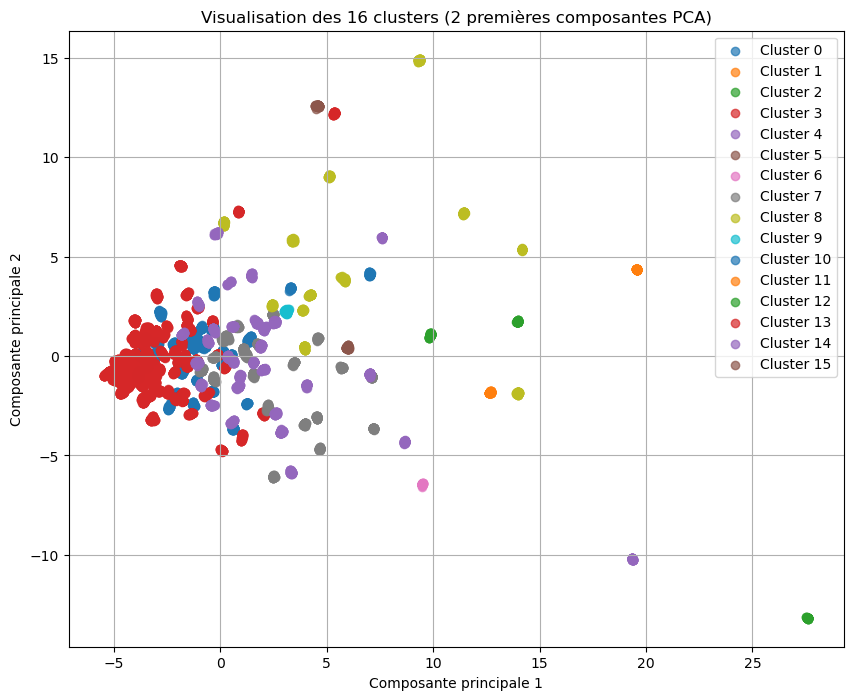

In [37]:
fixed_n_clusters = 16

# Création du modèle : appliquer la PCA à chaque fold et KMeans sur ces composantes
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=76)),  
    ('kmeans', KMeans(n_clusters=fixed_n_clusters, random_state=RANDOM_STATE, n_init=10))
])

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(gkf.split(features_train, groups=groups)):
    X_train_fold = features_train.iloc[train_idx].copy()
    X_val_fold = features_train.iloc[val_idx].copy()
    
    # On entraîne sur les données d'entraînement
    pipeline.fit(X_train_fold)
    
    # On récupère les prédictions de clusters pour les données d'entraînement
    cluster_labels_train = pipeline.named_steps['kmeans'].labels_
    
    # Prédictions de clusters pour les données de validation
    cluster_labels_val = pipeline.predict(X_val_fold)
    
# Entraînement du pipeline final
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=76)),
    ('kmeans', KMeans(n_clusters=fixed_n_clusters, random_state=RANDOM_STATE, n_init=10))
])
final_pipeline.fit(features_train)

# Clustering
cluster_assignments = final_pipeline.named_steps['kmeans'].labels_

# Ajout des clusters aux features
features_with_clusters = features_train.copy()
features_with_clusters['cluster'] = cluster_assignments

# Visualisation des clusters (2D => utilisation des deux premières composantes principales)
pca_result = final_pipeline.named_steps['pca'].transform(
    final_pipeline.named_steps['scaler'].transform(features_train)
)
visualisation_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'cluster': cluster_assignments
})

# Visualiser les clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(fixed_n_clusters):
    cluster_data = visualisation_df[visualisation_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.title(f'Visualisation des {fixed_n_clusters} clusters (2 premières composantes PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.grid(True)

## 7. Modèle supervisé

Comme observé dans la partie "Sélection du modèle", le modèle non optimisé qui donne les meilleures performances est le *Support Vector Machine* (pour la régression). Néanmoins, optimiser un tel modèle correctement nécessite une grande capacité computationnelle, et nous sommes de fait limités par la puissance de notre ordinateur.  

In [42]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # pas nécessaire pour RF, mais homogène avec le reste
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grille d’hyperparamètres raisonnable
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

# GridSearchCV
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=scorer,  # ou 'neg_mean_absolute_error'
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Entraînement
rf_grid.fit(features_train, train_labels_clean, groups=groups)

# Résultats
print("✅ Meilleurs hyperparamètres RF :", rf_grid.best_params_)
print("✅ MAE (CV) :", -rf_grid.best_score_)

# Récupération du meilleur modèle
best_rf_model = rf_grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Meilleurs hyperparamètres RF : {'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
✅ MAE (CV) : 0.5434741726950585


In [56]:
# ÉTAPE 1: Entraîner le modèle initial avec toutes les features
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Premier entraînement avec TOUTES les features
print("Entraînement du modèle initial avec toutes les features...")
rf_grid.fit(features_train, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF :", rf_grid.best_params_)
print("✅ MAE (CV) :", -rf_grid.best_score_)

# Récupération du meilleur modèle
best_rf_model = rf_grid.best_estimator_

# ÉTAPE 2: Extraire les features importantes
importances = best_rf_model.named_steps['rf'].feature_importances_
feature_names = features_train.columns.tolist()  # Récupère les noms réels des colonnes

# Créer un DataFrame pour faciliter la visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Utilise les noms réels des colonnes
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df.head(10))

# Obtenir les indices des 20 features les plus importantes
indices = np.argsort(importances)[::-1]
print("\nTop 10 features les plus importantes:")
for i in range(10):
    # Utiliser les noms réels des colonnes ici aussi
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Sélectionner les 20 meilleures features
top_indices = indices[:20]
selected_columns = features_train.columns[top_indices]

# Puis sélectionner ces colonnes
X_train_top = features_train[selected_columns]

# ÉTAPE 4: Réentraîner un nouveau modèle sur les 20 meilleures features
rf_pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid_top = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid_top = GridSearchCV(
    estimator=rf_pipeline_top,
    param_grid=param_grid_top,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Second entraînement avec TOP 20 features
print("\nRéentraînement avec les 20 meilleures features...")
rf_grid_top.fit(X_train_top, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF (top 20):", rf_grid_top.best_params_)
print("✅ MAE (CV) avec top 20 features:", -rf_grid_top.best_score_)

# Comparaison des performances
print(f"\nMAE initiale: {-rf_grid.best_score_:.4f}")
print(f"MAE avec top 20 features: {-rf_grid_top.best_score_:.4f}")

Entraînement du modèle initial avec toutes les features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Meilleurs hyperparamètres RF : {'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
✅ MAE (CV) : 0.5434741726950585
                  Feature  Importance
280         sharpe_week_3    0.022157
278         sharpe_week_1    0.021759
281         sharpe_week_4    0.021320
25    rendement_I_1_lag_1    0.019794
279         sharpe_week_2    0.018261
6              weight_I_7    0.014908
2              weight_I_3    0.011335
150  rendement_X_1_lag_16    0.010479
22    rendement_I_1_lag_4    0.010063
4              weight_I_5    0.009763

Top 10 features les plus importantes:
  1. sharpe_week_3: 0.0222
  2. sharpe_week_1: 0.0218
  3. sharpe_week_4: 0.0213
  4. rendement_I_1_lag_1: 0.0198
  5. sharpe_week_2: 0.0183
  6. weight_I_7: 0.0149
  7. weight_I_3: 0.0113
  8. rendement_X_1_lag_16: 0.0105
  9. rendement_I_1_lag_4: 0.0101

In [52]:
# ÉTAPE 1: Entraîner le modèle initial avec toutes les features
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Premier entraînement avec TOUTES les features
print("Entraînement du modèle initial avec toutes les features...")
rf_grid.fit(X_train_pca_76, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF :", rf_grid.best_params_)
print("✅ MAE (CV) :", -rf_grid.best_score_)

# Récupération du meilleur modèle
best_rf_model = rf_grid.best_estimator_

# ÉTAPE 2: Extraire les features importantes
importances = best_rf_model.named_steps['rf'].feature_importances_
feature_names = X_train_pca_76.columns.tolist()  # Récupère les noms réels des colonnes

# Créer un DataFrame pour faciliter la visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Utilise les noms réels des colonnes
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df.head(10))

# Obtenir les indices des 20 features les plus importantes
indices = np.argsort(importances)[::-1]
print("\nTop 10 features les plus importantes:")
for i in range(10):
    # Utiliser les noms réels des colonnes ici aussi
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Sélectionner les 20 meilleures features
top_indices = indices[:20]
selected_columns = X_train_pca_76.columns[top_indices]

# Puis sélectionner ces colonnes
X_train_top = X_train_pca_76[selected_columns]

# ÉTAPE 4: Réentraîner un nouveau modèle sur les 20 meilleures features
rf_pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid_top = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid_top = GridSearchCV(
    estimator=rf_pipeline_top,
    param_grid=param_grid_top,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Second entraînement avec TOP 20 features
print("\nRéentraînement avec les 20 meilleures features...")
rf_grid_top.fit(X_train_top, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF (top 20):", rf_grid_top.best_params_)
print("✅ MAE (CV) avec top 20 features:", -rf_grid_top.best_score_)

# Comparaison des performances
print(f"\nMAE initiale: {-rf_grid.best_score_:.4f}")
print(f"MAE avec top 20 features: {-rf_grid_top.best_score_:.4f}")

Entraînement du modèle initial avec toutes les features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Meilleurs hyperparamètres RF : {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
✅ MAE (CV) : 0.5734870347829928
    Feature  Importance
144   PC145    0.013482
82     PC83    0.010608
103   PC104    0.010067
153   PC154    0.008850
178   PC179    0.008432
168   PC169    0.008137
156   PC157    0.007979
199   PC200    0.007833
194   PC195    0.007748
137   PC138    0.007581

Top 10 features les plus importantes:
  1. PC145: 0.0135
  2. PC83: 0.0106
  3. PC104: 0.0101
  4. PC154: 0.0089
  5. PC179: 0.0084
  6. PC169: 0.0081
  7. PC157: 0.0080
  8. PC200: 0.0078
  9. PC195: 0.0077
  10. PC138: 0.0076

Réentraînement avec les 20 meilleures features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Meilleurs hyperparamètres RF (top 20): {'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samp

In [57]:
# ÉTAPE 1: Entraîner le modèle initial XGBoost avec toutes les features
from xgboost import XGBRegressor

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Premier entraînement avec TOUTES les features
print("Entraînement du modèle XGBoost initial avec toutes les features...")
xgb_grid.fit(features_train, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres XGBoost :", xgb_grid.best_params_)
print("✅ MAE (CV) :", -xgb_grid.best_score_)

# Récupération du meilleur modèle
best_xgb_model = xgb_grid.best_estimator_

# ÉTAPE 2: Extraire les features importantes
importances = best_xgb_model.named_steps['xgb'].feature_importances_
feature_names = features_train.columns.tolist()  # Récupère les noms réels des colonnes

# Créer un DataFrame pour faciliter la visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df.head(10))

# Obtenir les indices des 20 features les plus importantes
indices = np.argsort(importances)[::-1]
print("\nTop 10 features les plus importantes:")
for i in range(10):
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Sélectionner les 20 meilleures features
top_indices = indices[:20]
selected_columns = features_train.columns[top_indices]

# Puis sélectionner ces colonnes
X_train_top = features_train[selected_columns]

# ÉTAPE 4: Réentraîner un nouveau modèle XGBoost sur les 20 meilleures features
xgb_pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid_top = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

xgb_grid_top = GridSearchCV(
    estimator=xgb_pipeline_top,
    param_grid=param_grid_top,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Second entraînement avec TOP 20 features
print("\nRéentraînement XGBoost avec les 20 meilleures features...")
xgb_grid_top.fit(X_train_top, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres XGBoost (top 20):", xgb_grid_top.best_params_)
print("✅ MAE (CV) avec top 20 features:", -xgb_grid_top.best_score_)

# Comparaison des performances
print(f"\nMAE initiale (XGBoost): {-xgb_grid.best_score_:.4f}")
print(f"MAE avec top 20 features (XGBoost): {-xgb_grid_top.best_score_:.4f}")

Entraînement du modèle XGBoost initial avec toutes les features...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Meilleurs hyperparamètres XGBoost : {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
✅ MAE (CV) : 0.5649433295205697
                  Feature  Importance
70   rendement_I_4_lag_16    0.013284
126   rendement_I_6_lag_0    0.012758
60    rendement_I_3_lag_6    0.012183
239           cov_I_3_X_3    0.011970
83    rendement_I_4_lag_3    0.011900
236           cov_I_2_X_3    0.010964
57    rendement_I_3_lag_9    0.010925
247           cov_I_6_X_2    0.010650
268              skew_X_2    0.010583
227           cov_I_6_I_7    0.010255

Top 10 features les plus importantes:
  1. rendement_I_4_lag_16: 0.0133
  2. rendement_I_6_lag_0: 0.0128
  3. rendement_I_3_lag_6: 0.0122
  4. cov_I_3_X_3: 0.0120
  5. rendement_I_4_lag_3: 0.0119
  6. cov_I_2_X_3: 0.0110
  7. rendement_I_3_lag_9: 0.0109

In [53]:
# ÉTAPE 1: Entraîner le modèle initial XGBoost avec toutes les features
from xgboost import XGBRegressor

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Premier entraînement avec TOUTES les features
print("Entraînement du modèle XGBoost initial avec toutes les features...")
xgb_grid.fit(X_train_pca_76, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres XGBoost :", xgb_grid.best_params_)
print("✅ MAE (CV) :", -xgb_grid.best_score_)

# Récupération du meilleur modèle
best_xgb_model = xgb_grid.best_estimator_

# ÉTAPE 2: Extraire les features importantes
importances = best_xgb_model.named_steps['xgb'].feature_importances_
feature_names = X_train_pca_76.columns.tolist()  # Récupère les noms réels des colonnes

# Créer un DataFrame pour faciliter la visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df.head(10))

# Obtenir les indices des 20 features les plus importantes
indices = np.argsort(importances)[::-1]
print("\nTop 10 features les plus importantes:")
for i in range(10):
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Sélectionner les 20 meilleures features
top_indices = indices[:20]
selected_columns = X_train_pca_76.columns[top_indices]

# Puis sélectionner ces colonnes
X_train_top = X_train_pca_76[selected_columns]

# ÉTAPE 4: Réentraîner un nouveau modèle XGBoost sur les 20 meilleures features
xgb_pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid_top = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

xgb_grid_top = GridSearchCV(
    estimator=xgb_pipeline_top,
    param_grid=param_grid_top,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Second entraînement avec TOP 20 features
print("\nRéentraînement XGBoost avec les 20 meilleures features...")
xgb_grid_top.fit(X_train_top, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres XGBoost (top 20):", xgb_grid_top.best_params_)
print("✅ MAE (CV) avec top 20 features:", -xgb_grid_top.best_score_)

# Comparaison des performances
print(f"\nMAE initiale (XGBoost): {-xgb_grid.best_score_:.4f}")
print(f"MAE avec top 20 features (XGBoost): {-xgb_grid_top.best_score_:.4f}")

Entraînement du modèle XGBoost initial avec toutes les features...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Meilleurs hyperparamètres XGBoost : {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__subsample': 0.8}
✅ MAE (CV) : 0.5823698861177828
    Feature  Importance
37     PC38    0.030228
196   PC197    0.025902
195   PC196    0.022917
163   PC164    0.022456
29     PC30    0.022363
144   PC145    0.022133
82     PC83    0.021968
165   PC166    0.021925
203   PC204    0.021859
5       PC6    0.021842

Top 10 features les plus importantes:
  1. PC38: 0.0302
  2. PC197: 0.0259
  3. PC196: 0.0229
  4. PC164: 0.0225
  5. PC30: 0.0224
  6. PC145: 0.0221
  7. PC83: 0.0220
  8. PC166: 0.0219
  9. PC204: 0.0219
  10. PC6: 0.0218

Réentraînement XGBoost avec les 20 meilleures features...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Meilleurs hyperparamètres XGBoost (top 20): {'xgb__colsample_

In [ ]:
# ÉTAPE 1: Entraîner le modèle initial avec toutes les features
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # pas nécessaire pour RF, mais homogène avec le reste
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grille d'hyperparamètres plus complète
param_grid = {
    'rf__n_estimators': np.linspace(50, 500, 10, dtype=int),
    'rf__max_depth': np.linspace(5, 30, 6, dtype=int),
    'rf__min_samples_split': np.linspace(2, 20, 5, dtype=int),
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Premier entraînement avec TOUTES les features
print("Entraînement du modèle initial avec toutes les features...")
rf_grid.fit(features_train, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF :", rf_grid.best_params_)
print("✅ MAE (CV) :", -rf_grid.best_score_)

# Récupération du meilleur modèle
best_rf_model = rf_grid.best_estimator_

# ÉTAPE 2: Extraire les features importantes
importances = best_rf_model.named_steps['rf'].feature_importances_
feature_names = features_train.columns.tolist()

# Créer un DataFrame pour faciliter la visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df.head(10))

# Obtenir les indices des 20 features les plus importantes
indices = np.argsort(importances)[::-1]
print("\nTop 10 features les plus importantes:")
for i in range(10):
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Sélectionner les 20 meilleures features
top_indices = indices[:20]
selected_columns = features_train.columns[top_indices]

# Puis sélectionner ces colonnes
X_train_top = features_train[selected_columns]

# ÉTAPE 3: Réentraîner un nouveau modèle sur les 20 meilleures features
rf_pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Utiliser la même grille d'hyperparamètres complète pour le modèle top features
param_grid_top = {
    'rf__n_estimators': np.linspace(50, 500, 10, dtype=int),
    'rf__max_depth': np.linspace(5, 30, 6, dtype=int),
    'rf__min_samples_split': np.linspace(2, 20, 5, dtype=int),
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid_top = GridSearchCV(
    estimator=rf_pipeline_top,
    param_grid=param_grid_top,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Second entraînement avec TOP 20 features
print("\nRéentraînement avec les 20 meilleures features...")
rf_grid_top.fit(X_train_top, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF (top 20):", rf_grid_top.best_params_)
print("✅ MAE (CV) avec top 20 features:", -rf_grid_top.best_score_)

# Récupération du meilleur modèle avec les top features
best_rf_model_top = rf_grid_top.best_estimator_

# Comparaison des performances
print(f"\nMAE initiale: {-rf_grid.best_score_:.4f}")
print(f"MAE avec top 20 features: {-rf_grid_top.best_score_:.4f}")

In [ ]:
# ÉTAPE 1: Entraîner le modèle initial avec toutes les features
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # pas nécessaire pour RF, mais homogène avec le reste
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grille d'hyperparamètres plus complète
param_grid = {
    'rf__n_estimators': np.linspace(50, 500, 10, dtype=int),
    'rf__max_depth': np.linspace(5, 30, 6, dtype=int),
    'rf__min_samples_split': np.linspace(2, 20, 5, dtype=int),
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Premier entraînement avec TOUTES les features
print("Entraînement du modèle initial avec toutes les features...")
rf_grid.fit(X_train_pca_76, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF :", rf_grid.best_params_)
print("✅ MAE (CV) :", -rf_grid.best_score_)

# Récupération du meilleur modèle
best_rf_model = rf_grid.best_estimator_

# ÉTAPE 2: Extraire les features importantes
importances = best_rf_model.named_steps['rf'].feature_importances_
feature_names = X_train_pca_76.columns.tolist()

# Créer un DataFrame pour faciliter la visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df.head(10))

# Obtenir les indices des 20 features les plus importantes
indices = np.argsort(importances)[::-1]
print("\nTop 10 features les plus importantes:")
for i in range(10):
    print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Sélectionner les 20 meilleures features
top_indices = indices[:20]
selected_columns = X_train_pca_76.columns[top_indices]

# Puis sélectionner ces colonnes
X_train_top = X_train_pca_76[selected_columns]

# ÉTAPE 3: Réentraîner un nouveau modèle sur les 20 meilleures features
rf_pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Utiliser la même grille d'hyperparamètres complète pour le modèle top features
param_grid_top = {
    'rf__n_estimators': np.linspace(50, 500, 10, dtype=int),
    'rf__max_depth': np.linspace(5, 30, 6, dtype=int),
    'rf__min_samples_split': np.linspace(2, 20, 5, dtype=int),
    'rf__max_features': ['sqrt', 'log2']
}

rf_grid_top = GridSearchCV(
    estimator=rf_pipeline_top,
    param_grid=param_grid_top,
    scoring=scorer,
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Second entraînement avec TOP 20 features
print("\nRéentraînement avec les 20 meilleures features...")
rf_grid_top.fit(X_train_top, train_labels_clean, groups=groups)
print("✅ Meilleurs hyperparamètres RF (top 20):", rf_grid_top.best_params_)
print("✅ MAE (CV) avec top 20 features:", -rf_grid_top.best_score_)

# Récupération du meilleur modèle avec les top features
best_rf_model_top = rf_grid_top.best_estimator_

# Comparaison des performances
print(f"\nMAE initiale: {-rf_grid.best_score_:.4f}")
print(f"MAE avec top 20 features: {-rf_grid_top.best_score_:.4f}")

In [ ]:
def train_model_with_feature_selection(model_type='rf', features_train=None, train_labels=None, groups=None, 
                                      scorer=None, gkf=None, n_top_features=20):
    """
    Entraîne un modèle, sélectionne les features importantes et réentraîne avec les top features
    
    Parameters:
    -----------
    model_type : str, 'rf' ou 'xgb'
        Type de modèle à utiliser (RandomForest ou XGBoost)
    features_train : DataFrame
        Features d'entraînement
    train_labels : Series
        Labels d'entraînement
    groups : array-like
        Groupes pour le cross-validation
    scorer : callable
        Fonction d'évaluation
    gkf : cross-validator
        Stratégie de cross-validation
    n_top_features : int
        Nombre de features importantes à sélectionner
        
    Returns:
    --------
    dict
        Dictionnaire contenant les modèles et métriques
    """
    # Configuration du modèle selon le type
    if model_type == 'rf':
        from sklearn.ensemble import RandomForestRegressor
        
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
        ])
        
        param_grid = {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__max_features': ['sqrt', 'log2']
        }
        
        model_name = "RandomForest"
        
    elif model_type == 'xgb':
        from xgboost import XGBRegressor
        
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(random_state=42, n_jobs=-1))
        ])
        
        param_grid = {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.1],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
        
        model_name = "XGBoost"
    
    else:
        raise ValueError("model_type doit être 'rf' ou 'xgb'")
    
    # ÉTAPE 1: Premier GridSearch avec toutes les features
    print(f"Entraînement du modèle {model_name} initial avec toutes les features...")
    
    grid = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=scorer,
        cv=gkf,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(features_train, train_labels, groups=groups)
    
    print(f"✅ Meilleurs hyperparamètres {model_name} :", grid.best_params_)
    print(f"✅ MAE (CV) :", -grid.best_score_)
    
    # Récupération du meilleur modèle
    best_model = grid.best_estimator_
    
    # ÉTAPE 2: Extraction des features importantes
    importances = best_model.named_steps['model'].feature_importances_
    feature_names = features_train.columns.tolist()
    
    # Créer un DataFrame pour visualisation
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Trier par importance décroissante
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    print(feature_importance_df.head(10))
    
    # Obtenir les indices des features les plus importantes
    indices = np.argsort(importances)[::-1]
    
    print(f"\nTop 10 features les plus importantes:")
    for i in range(min(10, len(indices))):
        print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Sélectionner les top features
    top_indices = indices[:n_top_features]
    selected_columns = features_train.columns[top_indices]
    
    # Puis sélectionner ces colonnes
    X_train_top = features_train[selected_columns]
    
    # ÉTAPE 3: Réentraîner un nouveau modèle sur les top features
    model_pipeline_top = Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_model.named_steps['model'].__class__(random_state=42, n_jobs=-1))
    ])
    
    # Utiliser le même param_grid pour la cohérence
    grid_top = GridSearchCV(
        estimator=model_pipeline_top,
        param_grid=param_grid,
        scoring=scorer,
        cv=gkf,
        n_jobs=-1,
        verbose=1
    )
    
    # Second entraînement avec TOP features
    print(f"\nRéentraînement {model_name} avec les {n_top_features} meilleures features...")
    grid_top.fit(X_train_top, train_labels, groups=groups)
    
    print(f"✅ Meilleurs hyperparamètres {model_name} (top {n_top_features}):", grid_top.best_params_)
    print(f"✅ MAE (CV) avec top {n_top_features} features:", -grid_top.best_score_)
    
    # Comparaison des performances
    print(f"\nMAE initiale ({model_name}): {-grid.best_score_:.4f}")
    print(f"MAE avec top {n_top_features} features ({model_name}): {-grid_top.best_score_:.4f}")
    
    # Retourner les résultats
    return {
        'initial_model': best_model,
        'top_features_model': grid_top.best_estimator_,
        'initial_score': -grid.best_score_,
        'top_features_score': -grid_top.best_score_,
        'top_features': selected_columns.tolist(),
        'feature_importances': feature_importance_df
    }

In [65]:
# Pour Random Forest avec les features originales
rf_results = train_model_with_feature_selection(
    model_type='rf',
    features_train=features_train,
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)

# Pour XGBoost avec les features originales
xgb_results = train_model_with_feature_selection(
    model_type='xgb',
    features_train=features_train,
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)

# Pour Random Forest avec X_pca
rf_results_pca = train_model_with_feature_selection(
    model_type='rf',
    features_train=X_train_pca_76,  # Utilisation des features PCA
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)

# Pour XGBoost avec X_pca
xgb_results_pca = train_model_with_feature_selection(
    model_type='xgb',
    features_train=X_train_pca_76,  # Utilisation des features PCA
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)

# Récupération des modèles (features originales)
best_rf_model = rf_results['initial_model']
best_rf_top_model = rf_results['top_features_model']

best_xgb_model = xgb_results['initial_model']
best_xgb_top_model = xgb_results['top_features_model']

# Récupération des modèles (PCA)
best_rf_model_pca = rf_results_pca['initial_model']
best_rf_top_model_pca = rf_results_pca['top_features_model']

best_xgb_model_pca = xgb_results_pca['initial_model']
best_xgb_top_model_pca = xgb_results_pca['top_features_model']

# Comparaison des performances
print("\n=== Comparaison des modèles avec features originales ===")
print(f"RF - Toutes features: {rf_results['initial_score']:.4f}")
print(f"RF - Top features: {rf_results['top_features_score']:.4f}")
print(f"XGB - Toutes features: {xgb_results['initial_score']:.4f}")
print(f"XGB - Top features: {xgb_results['top_features_score']:.4f}")

print("\n=== Comparaison des modèles avec PCA ===")
print(f"RF - Toutes composantes PCA: {rf_results_pca['initial_score']:.4f}")
print(f"RF - Top composantes PCA: {rf_results_pca['top_features_score']:.4f}")
print(f"XGB - Toutes composantes PCA: {xgb_results_pca['initial_score']:.4f}")
print(f"XGB - Top composantes PCA: {xgb_results_pca['top_features_score']:.4f}")

# Déterminer le meilleur modèle global
scores = [
    rf_results['initial_score'],
    rf_results['top_features_score'],
    xgb_results['initial_score'],
    xgb_results['top_features_score'],
    rf_results_pca['initial_score'],
    rf_results_pca['top_features_score'],
    xgb_results_pca['initial_score'],
    xgb_results_pca['top_features_score']
]

models = [
    "RF - Toutes features originales",
    "RF - Top features originales",
    "XGB - Toutes features originales",
    "XGB - Top features originales",
    "RF - Toutes composantes PCA",
    "RF - Top composantes PCA",
    "XGB - Toutes composantes PCA",
    "XGB - Top composantes PCA"
]

best_idx = scores.index(min(scores))
print(f"\n✅ Le meilleur modèle est: {models[best_idx]} avec un MAE de {scores[best_idx]:.4f}")

Entraînement du modèle RandomForest initial avec toutes les features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Meilleurs hyperparamètres RandomForest : {'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_split': 5, 'model__n_estimators': 50}
✅ MAE (CV) : 0.5434741726950585
                  Feature  Importance
280         sharpe_week_3    0.022157
278         sharpe_week_1    0.021759
281         sharpe_week_4    0.021320
25    rendement_I_1_lag_1    0.019794
279         sharpe_week_2    0.018261
6              weight_I_7    0.014908
2              weight_I_3    0.011335
150  rendement_X_1_lag_16    0.010479
22    rendement_I_1_lag_4    0.010063
4              weight_I_5    0.009763

Top 10 features les plus importantes:
  1. sharpe_week_3: 0.0222
  2. sharpe_week_1: 0.0218
  3. sharpe_week_4: 0.0213
  4. rendement_I_1_lag_1: 0.0198
  5. sharpe_week_2: 0.0183
  6. weight_I_7: 0.0149
  7. weight_I_3: 0.0113
  8. rendement_X_1_lag_16: 0.01

In [66]:
# Fonction avec linspace
def train_model_with_feature_selection(model_type='rf', features_train=None, train_labels=None, groups=None, 
                                      scorer=None, gkf=None, n_top_features=20):
    """
    Entraîne un modèle, sélectionne les features importantes et réentraîne avec les top features
    
    Parameters:
    -----------
    model_type : str, 'rf' ou 'xgb'
        Type de modèle à utiliser (RandomForest ou XGBoost)
    features_train : DataFrame
        Features d'entraînement
    train_labels : Series
        Labels d'entraînement
    groups : array-like
        Groupes pour le cross-validation
    scorer : callable
        Fonction d'évaluation
    gkf : cross-validator
        Stratégie de cross-validation
    n_top_features : int
        Nombre de features importantes à sélectionner
        
    Returns:
    --------
    dict
        Dictionnaire contenant les modèles et métriques
    """
    # Configuration du modèle selon le type
    if model_type == 'rf':
        from sklearn.ensemble import RandomForestRegressor
        
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
        ])
        
        param_grid = {
            'model__n_estimators': np.linspace(50, 500, 10, dtype=int),
            'model__max_depth': np.linspace(5, 30, 6, dtype=int),
            'model__min_samples_split': np.linspace(2, 20, 5, dtype=int),
            'model__max_features': ['sqrt', 'log2']
        }
        
        model_name = "RandomForest"
        
    elif model_type == 'xgb':
        from xgboost import XGBRegressor
        
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(random_state=42, n_jobs=-1))
        ])
        
        param_grid = {
            'model__n_estimators': np.linspace(50, 500, 10, dtype=int),
            'model__max_depth': np.linspace(3, 15, 5, dtype=int),
            'model__learning_rate': [0.01, 0.1],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
        
        model_name = "XGBoost"
    
    else:
        raise ValueError("model_type doit être 'rf' ou 'xgb'")
    
    # ÉTAPE 1: Premier GridSearch avec toutes les features
    print(f"Entraînement du modèle {model_name} initial avec toutes les features...")
    
    grid = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=scorer,
        cv=gkf,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(features_train, train_labels, groups=groups)
    
    print(f"✅ Meilleurs hyperparamètres {model_name} :", grid.best_params_)
    print(f"✅ MAE (CV) :", -grid.best_score_)
    
    # Récupération du meilleur modèle
    best_model = grid.best_estimator_
    
    # ÉTAPE 2: Extraction des features importantes
    importances = best_model.named_steps['model'].feature_importances_
    feature_names = features_train.columns.tolist()
    
    # Créer un DataFrame pour visualisation
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Trier par importance décroissante
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    print(feature_importance_df.head(10))
    
    # Obtenir les indices des features les plus importantes
    indices = np.argsort(importances)[::-1]
    
    print(f"\nTop 10 features les plus importantes:")
    for i in range(min(10, len(indices))):
        print(f"  {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Sélectionner les top features
    top_indices = indices[:n_top_features]
    selected_columns = features_train.columns[top_indices]
    
    # Puis sélectionner ces colonnes
    X_train_top = features_train[selected_columns]
    
    # ÉTAPE 3: Réentraîner un nouveau modèle sur les top features
    model_pipeline_top = Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_model.named_steps['model'].__class__(random_state=42, n_jobs=-1))
    ])
    
    # Utiliser le même param_grid pour la cohérence
    grid_top = GridSearchCV(
        estimator=model_pipeline_top,
        param_grid=param_grid,
        scoring=scorer,
        cv=gkf,
        n_jobs=-1,
        verbose=1
    )
    
    # Second entraînement avec TOP features
    print(f"\nRéentraînement {model_name} avec les {n_top_features} meilleures features...")
    grid_top.fit(X_train_top, train_labels, groups=groups)
    
    print(f"✅ Meilleurs hyperparamètres {model_name} (top {n_top_features}):", grid_top.best_params_)
    print(f"✅ MAE (CV) avec top {n_top_features} features:", -grid_top.best_score_)
    
    # Comparaison des performances
    print(f"\nMAE initiale ({model_name}): {-grid.best_score_:.4f}")
    print(f"MAE avec top {n_top_features} features ({model_name}): {-grid_top.best_score_:.4f}")
    
    # Retourner les résultats
    return {
        'initial_model': best_model,
        'top_features_model': grid_top.best_estimator_,
        'initial_score': -grid.best_score_,
        'top_features_score': -grid_top.best_score_,
        'top_features': selected_columns.tolist(),
        'feature_importances': feature_importance_df
    }

In [ ]:
# Pour Random Forest avec les features originales
rf_results = train_model_with_feature_selection(
    model_type='rf',
    features_train=features_train,
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)


Entraînement du modèle RandomForest initial avec toutes les features...
Fitting 5 folds for each of 600 candidates, totalling 3000 fits


In [ ]:
# Pour XGBoost avec les features originales
xgb_results = train_model_with_feature_selection(
    model_type='xgb',
    features_train=features_train,
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)


In [ ]:
# Pour Random Forest avec X_pca
rf_results_pca = train_model_with_feature_selection(
    model_type='rf',
    features_train=X_train_pca_76,  # Utilisation des features PCA
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)

In [ ]:
# Pour XGBoost avec X_pca
xgb_results_pca = train_model_with_feature_selection(
    model_type='xgb',
    features_train=X_train_pca_76,  # Utilisation des features PCA
    train_labels=train_labels_clean,
    groups=groups,
    scorer=scorer,
    gkf=gkf
)

In [ ]:
# Récupération des modèles (features originales)
best_rf_model = rf_results['initial_model']
best_rf_top_model = rf_results['top_features_model']

best_xgb_model = xgb_results['initial_model']
best_xgb_top_model = xgb_results['top_features_model']

# Récupération des modèles (PCA)
best_rf_model_pca = rf_results_pca['initial_model']
best_rf_top_model_pca = rf_results_pca['top_features_model']

best_xgb_model_pca = xgb_results_pca['initial_model']
best_xgb_top_model_pca = xgb_results_pca['top_features_model']

# Comparaison des performances
print("\n=== Comparaison des modèles avec features originales ===")
print(f"RF - Toutes features: {rf_results['initial_score']:.4f}")
print(f"RF - Top features: {rf_results['top_features_score']:.4f}")
print(f"XGB - Toutes features: {xgb_results['initial_score']:.4f}")
print(f"XGB - Top features: {xgb_results['top_features_score']:.4f}")

print("\n=== Comparaison des modèles avec PCA ===")
print(f"RF - Toutes composantes PCA: {rf_results_pca['initial_score']:.4f}")
print(f"RF - Top composantes PCA: {rf_results_pca['top_features_score']:.4f}")
print(f"XGB - Toutes composantes PCA: {xgb_results_pca['initial_score']:.4f}")
print(f"XGB - Top composantes PCA: {xgb_results_pca['top_features_score']:.4f}")

# Déterminer le meilleur modèle global
scores = [
    rf_results['initial_score'],
    rf_results['top_features_score'],
    xgb_results['initial_score'],
    xgb_results['top_features_score'],
    rf_results_pca['initial_score'],
    rf_results_pca['top_features_score'],
    xgb_results_pca['initial_score'],
    xgb_results_pca['top_features_score']
]

models = [
    "RF - Toutes features originales",
    "RF - Top features originales",
    "XGB - Toutes features originales",
    "XGB - Top features originales",
    "RF - Toutes composantes PCA",
    "RF - Top composantes PCA",
    "XGB - Toutes composantes PCA",
    "XGB - Top composantes PCA"
]

best_idx = scores.index(min(scores))
print(f"\n✅ Le meilleur modèle est: {models[best_idx]} avec un MAE de {scores[best_idx]:.4f}")

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # pas nécessaire pour RF, mais homogène avec le reste
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grille d’hyperparamètres raisonnable
param_grid = {
    'rf__n_estimators': np.linspace(50, 500, 10, dtype=int),
    'rf__max_depth': np.linspace(5, 30, 6, dtype=int),
    'rf__min_samples_split': np.linspace(2, 20, 5, dtype=int),
    'rf__max_features': ['sqrt', 'log2']
}

# GridSearchCV
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring=scorer,  # ou 'neg_mean_absolute_error'
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

# Entraînement
rf_grid.fit(features_train, train_labels_clean, groups=groups)

# Résultats
print("✅ Meilleurs hyperparamètres RF :", rf_grid.best_params_)
print("✅ MAE (CV) :", -rf_grid.best_score_)

# Récupération du meilleur modèle
best_rf_model = rf_grid.best_estimator_

## 9. Modèles de deep learning

## 10. Comparaison des résultats

## 11. XAI